<img src="../../img/horse-colic.png">

# Индивидуальный проект по анализу данных

## Horse Colic Dataset

Всем привет, героем сегодняшнего дня станет достаточно интересный датасет на медицинскую тематику, а именно, встречайте Horse Colic Dataset. Сие чудо обитает на [kaggle](https://www.kaggle.com/uciml/horse-colic), куда он в свою очередь пришел с архива датасетов [UCI](https://archive.ics.uci.edu/ml/datasets/Horse+Colic).

Основной задачей в данном датасете является предсказание возможной смерти лошади на основе текущего состояния и прошлых заболеваний. Соотвественно ценность решаемой задачи в том, что было бы хорошо иметь модель, предсказывающую исход для конкретной лошади по текущему состоянию, что позволило бы вовремя производить хирургическое вмешательство во имя спасения жизни. Как мы увидим позже, человеку достаточно тяжело сделать точные выводы на основе такого количества медицинских признаков.

Если более конкретно, то стоит задача мультиклассовой классификации (3 класса) на типичных медицинских данных: очень мало данных, много признаков и ооочень много пропусков (порядка 30%). Но если пропуски можно заполнить, то проблема количества данных стоит очень остро.

Хочу сразу предупредить, что делал ацент именно на EDA, а не на стакинге 10 бустингов и переборе всех моделей подряд, поэтому уберите от экранов людей со слабой психикой. Давайте же приступим...

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
from pylab import rcParams

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA

%matplotlib inline
warnings.simplefilter('ignore')
rcParams['figure.figsize'] = 10, 8
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

Загружаем датасет и сразу видим, что большинство признаков категориальные. Чуть ниже я привел расшифровку каждого признака. Так как переводить медицинские термины, будучи далеким от медицины человеком, достаточно тяжело, не исключено, что я где-то ошибся.

In [4]:
horse_df = pd.read_csv('../../data/horse.csv')
horse_df.head(10)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no
5,no,adult,528355,NaN,NaN,NaN,warm,normal,pale_pink,less_3_sec,...,NaN,NaN,NaN,NaN,lived,no,0,0,0,no
6,yes,adult,526802,37.9,48.0,16.0,normal,normal,normal_pink,less_3_sec,...,37.0,7.0,NaN,NaN,lived,yes,3124,0,0,no
7,yes,adult,529607,NaN,60.0,NaN,cool,NaN,NaN,less_3_sec,...,44.0,8.3,NaN,NaN,died,yes,2208,0,0,no
8,no,adult,530051,NaN,80.0,36.0,cool,absent,pale_pink,less_3_sec,...,38.0,6.2,NaN,NaN,euthanized,yes,3205,0,0,no
9,no,young,5299629,38.3,90.0,NaN,normal,NaN,normal_pink,less_3_sec,...,40.0,6.2,clear,2.2,lived,no,0,0,0,yes


## Описание признаков

1: **Наличие операций (бинарный признак):**
    - 1 = да;
    - 2 = нет.

2: **Возраст (бинарный признак):**
    - 1 = взрослая лошадь;
    - 2 = молодая лоашадь (<6 месяцев).

3: **Номер больницы (категориальный признак):**
    - числовой идентификатор;
    - номер дела лошади (может быть не уникальным, если лошадь лечится > 1 раз).
    
4: **Ректальная температура (количественный признак):**
    - в градусах Цельсия;
    - повышенная температура может возникнуть из-за инфекции;
    - температура может быть уменьшена, когда лошадь находится в шоке;
    - нормальная температура составляет 37.8;
    - этот параметр обычно растет по мере прогрессирования болезни.
    
5: **Пульс (количественный признак):**
    - частота сердечных сокращений в ударах в минуту;
    - отражает состояние сердца: 30-40 норма для взрослых;
    - редко бывает меньше нормы, хотя атлетичные лошади могут иметь 20-25 ударов в минуту;
    - лошади с травмами или со спазмом сосудов могут иметь повышенную частоту сердечных сокращений.

6: **Частота дыхания (количественный признак):**
    - нормальная частота составляет от 8 до 10;
    - полезность сомнительна из-за больших колебаний.

7: **Температура конечностей (категориальный признак):**
    - субъективная оценка состояния кровообращения;
    - возможные значения:
        1 = Normal 
        2 = Warm
        3 = Cool
        4 = Cold
    - прохладные и холодные конечности указывают на возможный шок;
    - горячие конечности должны коррелировать с повышенной ректальной температурой.
    
8: **Венозный пульс (категориальный признак):**
    - возможные значения:
        1 = normal 
        2 = increased (повышенный)
        3 = reduced (сниженный)
        4 = absent (отсутсвует)
    - нормальный или увеличенный пульс указывают на адекватную циркуляцию, в то время как уменьшенный или отсутствующий
      указывает на плохое кровоснабжение.

9: **Цвет слизистой (категориальный признак):**
    - субъективная оценка цвета;
    - возможные значения:
        1 = normal pink (нормальный розовый)
        2 = bright pink (ярко-розовый)
        3 = pale pink (бледно-розовый)
        4 = pale cyanotic (бледно-цианотический)
        5 = bright red / injected  (ярко-красный)
        6 = dark cyanotic (темная цианотический)
    - 1 и 2 указывают на нормальную или слегка увеличенную циркуляцию
    - 3 может произойти в раннем шоке
    - 4 и 6 свидетельствуют о серьезном нарушении кровообращения
    - 5 больше указывает на септицемию (инфицированеи крови)

10: **Время заполнения капилляра (категориальный признак):**
    - чем дольше заполнение капилляра, тем хуже циркуляция;
    - возможные значения:
        1 = <3 секунды
        2 = >= 3 секунды
        3 = 3 cекунды
        
11: **Оценка уровня боли (категориальный признак):**
    - возможные значения:
        1 = alert, no pain (предупреждение, отсутствие боли)
        2 = depressed (подавлен)
        3 = intermittent mild pain (прерывистая слабая боль)
        4 = intermittent severe pain (прерывистая сильная боль)
        5 = continuous severe pain (непрерывная сильная боль)
    - НЕ следует рассматривать как упорядоченную или дискретную переменную!
    - в целом, чем больнее, тем более вероятно, что потребуется хирургическое вмешательство
    - предварительное лечение может в какой-то мере замаскировать уровень боли

12: **Сократимость кишечника (категориальный признак):**
    - указание на активность в кишечнике лошади;
    - возможные значения:
        1 = hypermotile
        2 = normal
        3 = hypomotile 
        4 = absent (отсутсвует)

13: **Метеоризм (категориальный признак):**
    - ВАЖНЫЙ параметр;
    - возможные значения
        1 = none (нет)
        2 = slight(незначительный)
        3 = moderate (умеренный)
        4 = severe (тяжелый)
    - лошадь с тяжелой стадией метеоризма, требует хирургического вмешательства.
    
14: **Назогастральная трубка (категориальный признак):**
    - возможные значения:
        1 = none (нет)
        2 = slight (незначительный)
        3 = significant (значительный)

15: **Рвота (категориальный признак):**
    - возможные значения
        1 = нет
        2 = >1 литра
        3 = <1 литра
    - чем больше рвота, тем больше вероятность того, что
      существует некоторая серьезная непроходимость в кишечнике.
      
16: **PH Рвоты (количественный признак):**
    - шкала от 0 до 14, 7 является нейтральным;
    - нормальные значения находятся в диапазоне от 3 до 4.
    
17: **Исследование фекалий (категориальный признак):**
    - возможные значения
        1 = normal (нормальный)
        2 = increased (повышенный)
        3 = decreased (сниженный)
        4 = absent (отсутствует)
    - отсутствие фекалий, вероятно, указывает на обстипацию.

18: **Состояние кишечника (категориальный признак):**
    - возможные значения
        1 = normal (нормально)
        2 = other (другое)
        3 = firm feces in the large intestine (твердые фекалии в толстой кишке)
        4 = distended small intestine (растянутый тонкий кишечник)
        5 = distended large intestine (растянутый толстый кишечник)
    - 4 и 5 требуют хирургического вмешательства

19: **Объем красных кровяных клеток в крови (количественный признак):**
    - количество красных клеток на единицу объема в крови;
    - нормальный диапазон от 30 до 50. Уровень повышается по мере того, как нарушается кровообращение или
      появляется обезвоживание.

20: **Общий белок (количественный признак):**
    - нормальные значения лежат в диапазоне 6-7,5 (gms / dL)
    - чем выше значение, тем больше обезвоживание
    
21: **Абдоминоцентез (категориальный признак):**
    - возможные значения:
        1 = clear
        2 = cloudy
        3 = serosanguinous
    - cloudy и serosanguinous указывает на проблемы с кишечником.
    
22: **Общий белок абдоминоцентеза (количественный признак):**
    - чем выше уровень белка, тем более вероятно, что есть проблемы с кишечником. Значения указаны в gms / dL
    
23: **Итог (целевой признак):**
    - что в итоге случилось с лошадью?
    - возможные значения:
        1 = выжила
        2 = умерла
        3 = была подвергнута эвтаназии (облегчение предсмертных страданий неизлечимо больных, умерщвление)
        
24: **Наличие операционных травм (бинарный признак):**
    - возможные значения:
        1 = Да
        2 = Нет
        
25, 26, 27: **Типы травм:**
    - состоит из 4 цифр;
    - первое число - место поражения:
        1 = желудок
        2 = тонкий кишечник
        3 = толстая кишка
        4 = толстая кишка и слепая кишка
        5 = слепая кишка
        6 = поперечная толстая кишка
        7 = обратная/нисходящая кишка
        8 = матка
        9 = мочевой пузырь
        11 = все кишечные участки
        00 = нет сведений
    - второе число - тип поражения:
        1 = простое поражение
        2 = приступ
        3 = воспаление
        4 = другое
    - третье число - подтип поражения:
        1 = механический
        2 = паралитический
        0 = нет сведений
    - четвертое число - спец. код:
        1 = обтурация
        2 = внутреннее поражение
        3 = внешнее поражение
        4 = адинамическое поражение
        5 = заворот кишок
        6 = поражение инвагинации
        7 = тромбоэмболическое поражение
        8 = грыжа
        9 = липома
        10 = смещение
        0 = нет сведений

28: **Патология (бинарный признак):**
    - имеeтся ли патология?
        1 = Да
        2 = Нет

Бросим беглый взгляд на пропуски всего датасета и увидим, что больше половины признаков таковые имеют. Дальше вернемся к ним более подробно. 

In [4]:
horse_df.isnull().any()

surgery                  False
age                      False
hospital_number          False
rectal_temp               True
pulse                     True
respiratory_rate          True
temp_of_extremities       True
peripheral_pulse          True
mucous_membrane           True
capillary_refill_time     True
pain                      True
peristalsis               True
abdominal_distention      True
nasogastric_tube          True
nasogastric_reflux        True
nasogastric_reflux_ph     True
rectal_exam_feces         True
abdomen                   True
packed_cell_volume        True
total_protein             True
abdomo_appearance         True
abdomo_protein            True
outcome                  False
surgical_lesion          False
lesion_1                 False
lesion_2                 False
lesion_3                 False
cp_data                  False
dtype: bool

Сразу отделим признаки от целевой переменной, которая носит название outcome

In [5]:
X = horse_df[horse_df.columns.difference(['outcome'])]
y = horse_df['outcome']

In [6]:
print('Объектов в датасете: {0}\nПризнаков: {1}'.format(X.shape[0], X.shape[1]))

Объектов в датасете: 299
Признаков: 27


А вот и численное подтверждение малочисленности данных, я бы даже сказал катострафической малочисленности. Невольно возникает вопрос, можно ли вообще выжать что-то хороше из них.

Разделим датасет на категориальные и количественные признаки, так дальше будет легче работать

In [7]:
numeric_features = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph',
                    'packed_cell_volume', 'total_protein', 'abdomo_protein']
categorial_features = X.columns.difference(numeric_features)

X_numeric = X[numeric_features]
X_categorial = X[categorial_features]

print('Категориальных признаков: {0}\nКоличественных признаков: {1}'.format(X_categorial.shape[1], X_numeric.shape[1]))

Категориальных признаков: 20
Количественных признаков: 7


Итак, входные данные: 299 объектов, 7 числовых признаков и 20 категориальных

## Описание целевой переменной

Построим небольшой counplot и посмотрим, какие есть классы и в каком они количестве

lived         60%
died          26%
euthanized    15%
Name: outcome, dtype: object


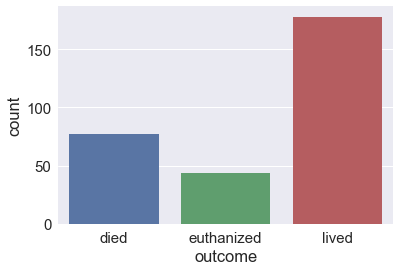

In [8]:
print((round(y.value_counts(normalize=True), 2) * 100).map(lambda x: '{0}%'.format(str(int(x)))))
sns.countplot(y);

Что ж, есть три класса: лошадь выжила, лошадь погибла и лошадь усыпыли, чтобы облегчить предсмертные страдания. Отсюда можно сделать первые выводы, классы died и euthanized очень похожи и по сути имеют одинаковый итог, поэтому велика вероятность, что их будет тяжело отделить друг от друга и они будут перемешиваться. По идее их можно объединить, но мы оставим как это задумывалось.

Второе, это то, что необходимо будет как-то сбалансировать классы. Например применить oversampling или выставить параметр weighted в моделях.

Третье, подобрать соответсвующую метрику, учитывающую дисбаланс классов.

Далее, так как признаков для анализа очень много, проанализируем количественные и категориальные признаки по отдельности.

## Анализ количественных признков

Убедимся, что все признаки количественные, кроме того уже виден масштаб пропущенных данных.

In [9]:
X_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
rectal_temp              239 non-null float64
pulse                    275 non-null float64
respiratory_rate         241 non-null float64
nasogastric_reflux_ph    53 non-null float64
packed_cell_volume       270 non-null float64
total_protein            266 non-null float64
abdomo_protein           101 non-null float64
dtypes: float64(7)
memory usage: 16.4 KB


Новая информация = новые выводы: стоит попробовать заполнить пропуски средним, медианой или более умными методами.

Посмотрим на статистические характеристики

In [10]:
X_numeric.describe()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
count,239.000000,275.000000,241.000000,53.000000,270.000000,266.000000,101.000000
mean,38.168619,72.000000,30.460581,4.707547,46.307407,24.274436,3.039604
std,0.733744,28.646219,17.666102,1.982311,10.436743,27.364194,1.967947
min,35.400000,30.000000,8.000000,1.000000,23.000000,3.300000,0.100000
25%,37.800000,48.000000,18.000000,3.000000,38.000000,6.500000,2.000000
50%,38.200000,64.000000,25.000000,5.000000,45.000000,7.500000,2.300000
75%,38.500000,88.000000,36.000000,6.500000,52.000000,56.750000,3.900000
max,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000


Можно косвенно говорить о наличии выбросов, если min и max по столбцам отличается от mean больше чем на порядок:
- rectal_temp:        все нормально
- pulse:              max отличается на порядок
- respiratory_rate:   min отличается на порядок
- nasogastric_ph:     все нормально
- packed_cell_volume: все нормально
- total_protein:      min отличается на порядок
- abdomo_protein:     min отличается на порядок

Стоит отметить, что нету каких-то экстремальных или кардинально неверных значений. Данные попались достаточно качественные, дальше мы это увидим.

Есть несколько вариантов, как работать с выбросами, от просто исключения и индексации странного события, до кросс-валидации с исключением выбросов на стадии оценки. Скорее всего ничего с ними делать не будем, так как данных мало, чтобы их исключать, но и не так много, чтобы заморачиваться с хитрой кросс-валидацией. На изображениях ниже, это будет видно.

Построим распределение для каждого признака по классам

In [11]:
X_numeric_y = X_numeric.copy()
X_numeric_y['outcome'] = y

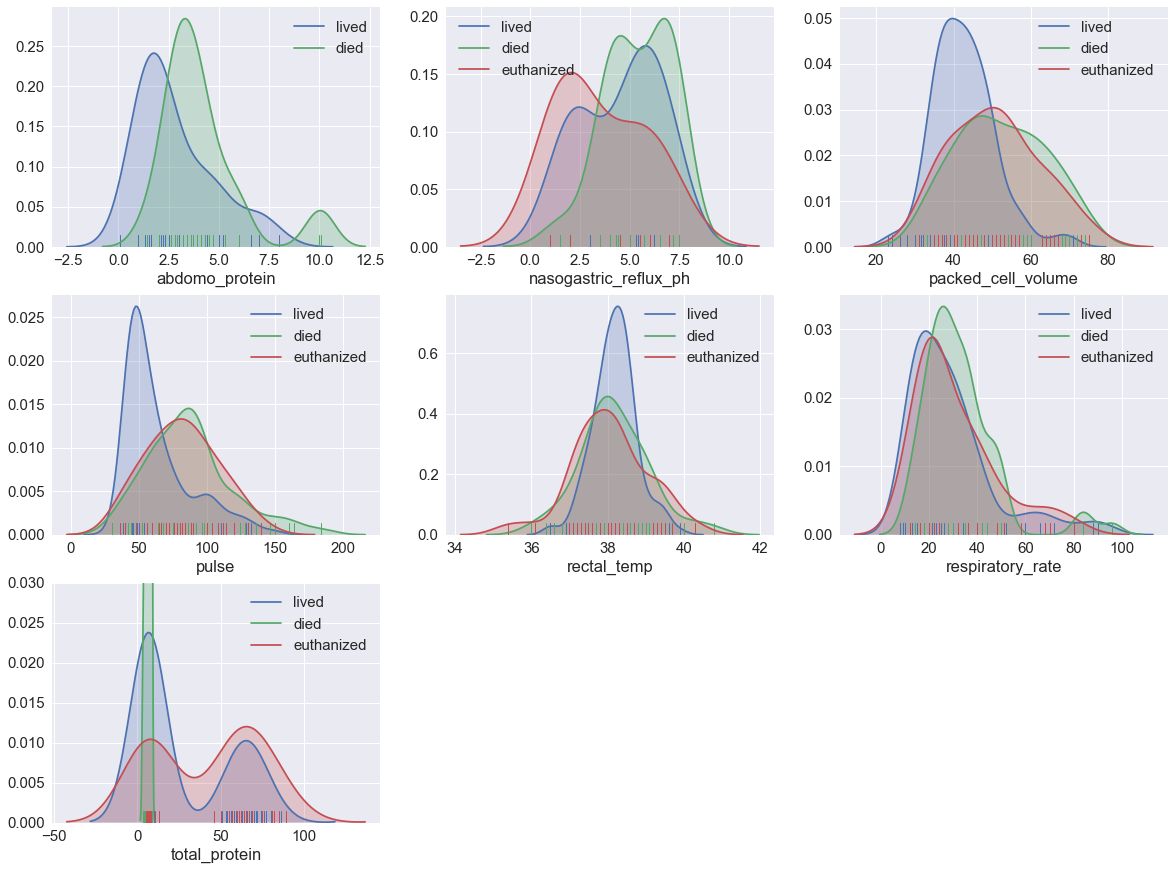

In [12]:
sns.set(font_scale=1.5)
rcParams['figure.figsize'] = 20, 15
subplot_position = 330
for column in X_numeric_y.columns.difference(['outcome']):
    
    lived = X_numeric_y.loc[X_numeric_y['outcome'] == 'lived']
    died = X_numeric_y.loc[X_numeric_y['outcome'] == 'died']
    euthanized = X_numeric_y.loc[X_numeric_y['outcome'] == 'euthanized']
    subplot_position += 1
    plt.subplot(subplot_position)
    sns.distplot(lived[column].dropna(), hist=False, rug=True, label='lived', kde_kws={"shade": True})
    sns.distplot(died[column].dropna(), hist=False, rug=True, label='died', kde_kws={"shade": True})
    if (column != 'abdomo_protein'):
        sns.distplot(euthanized[column].dropna(), hist=False, rug=True, label='euthanized', kde_kws={"shade": True})
    if (column == 'total_protein'):
        plt.ylim(0, 0.03)
    plt.legend()

К сожалению распределение euthanized для abdomo_protein вывести не получилось из-за малого количества данных.

Первое, что бросается в глаза, это то, что распределения отдаленно напоминают нормальное распределение (извините за тавтологию), что уже является хорошим знаком. Также присутствуют парочка логнормальных, которые стоит привести к нормальному.

Второе, как и ожидалось, с точки зрения количественных признаков, класс lived хорошо отличим, а два других очень похожи друг на друга.

Давайте проверим являются ли распределения нормальными с помощью критерия Шапиро-Уилка и посмотрим поможет ли логарифмирование.

In [13]:
from scipy.stats import shapiro

for column in X_numeric.columns:
    stat, p_value = shapiro(X_numeric[column].dropna())
    stat_log, p_value_log = shapiro(np.log(X_numeric[column].dropna()))
    
    print('{0}: ({1}, {2}) ==> ({3}, {4})\n'.format(column,
                                                           round(stat, 3),
                                                           round(p_value, 4),
                                                           round(stat_log, 3),
                                                           round(p_value_log, 4)))

rectal_temp: (0.977, 0.0006) ==> (0.977, 0.0006)

pulse: (0.913, 0.0) ==> (0.97, 0.0)

respiratory_rate: (0.844, 0.0) ==> (0.982, 0.0041)

nasogastric_reflux_ph: (0.917, 0.0013) ==> (0.857, 0.0)

packed_cell_volume: (0.957, 0.0) ==> (0.986, 0.0119)

total_protein: (0.656, 0.0) ==> (0.709, 0.0)

abdomo_protein: (0.869, 0.0) ==> (0.922, 0.0)



Что ж, ожидаемо, ни одно из распределений не является нормальным (< 0.05) ни до, ни после логарифмирования, но с логарифмированием дела в некоторых случаях явно идут на поправку.

Для разнообразия применим менее формальный метод, Q-Q график для признака pulse.

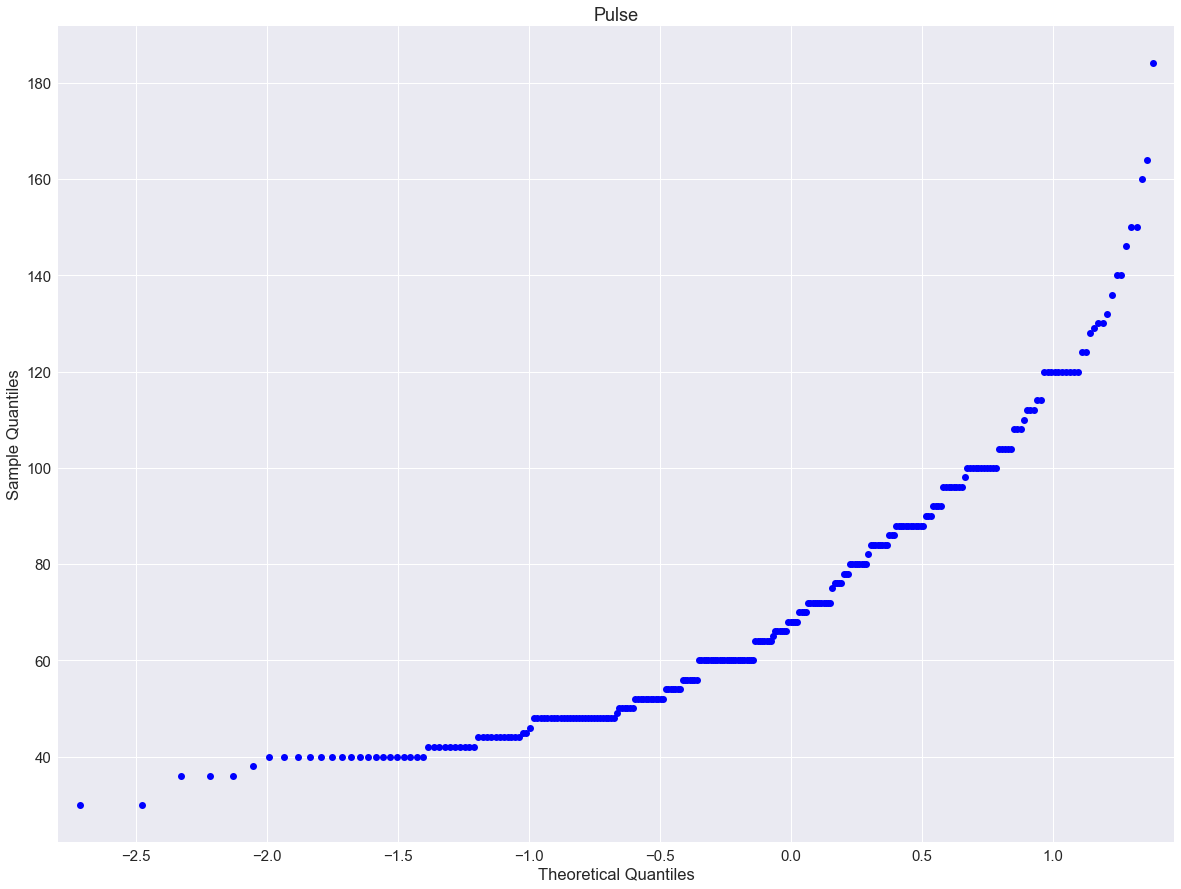

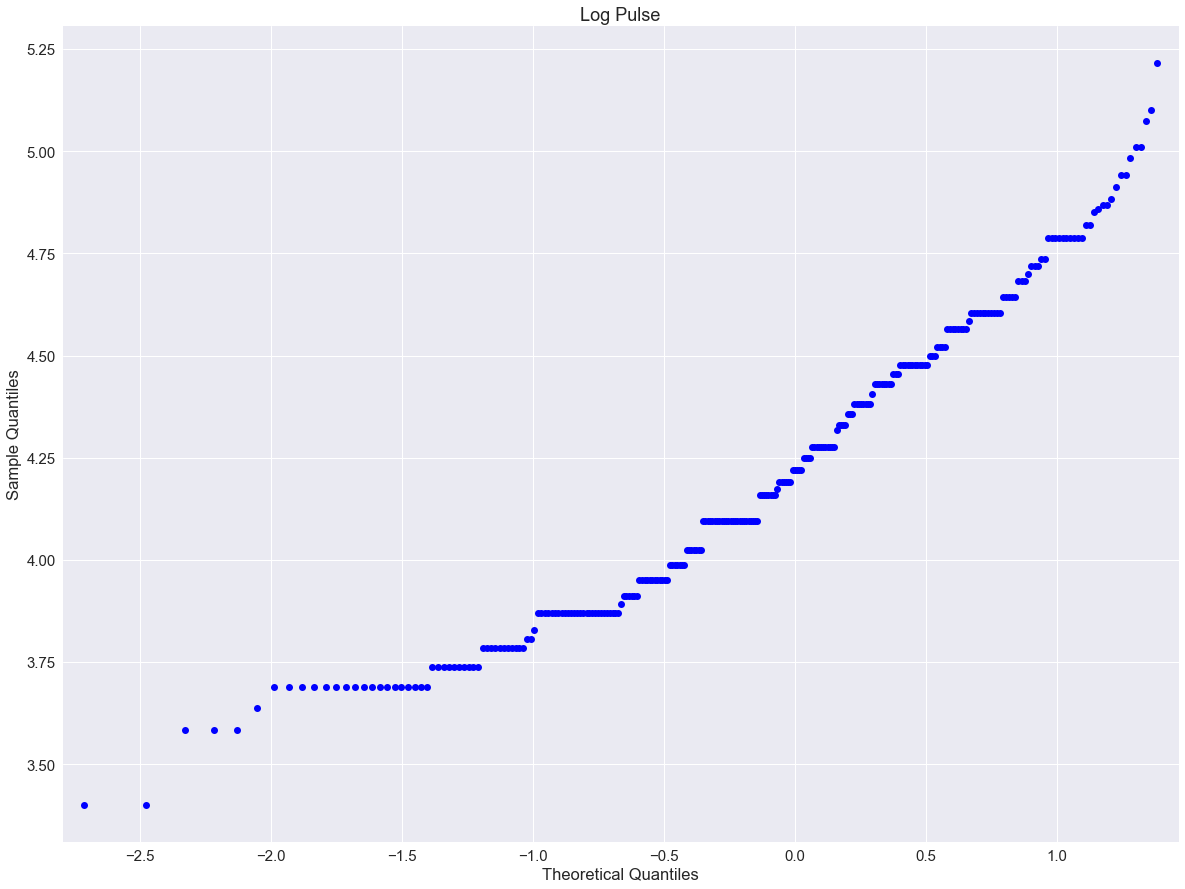

In [14]:
import statsmodels.api as sm
pulse = X_numeric['pulse']
log_pulse = np.log(X_numeric['pulse'])
qq = sm.qqplot(pulse, loc=pulse.mean(), scale=pulse.std())
plt.title('Pulse');
qq_log = sm.qqplot(log_pulse, loc=log_pulse.mean(), scale=log_pulse.std())
plt.title('Log Pulse');

Для нормального распределения он будет выглядеть как ровная диагональная линия, и визуальные отклонения интуитивно понятны. Q-Q график признака после логарифмирования показывает, что пролагорифмировать определенно стоит.

Построим boxplot для каждого признака без привязки к классам. И снова сделаем выводы.

Первое, признаки имеют разный масштаб, что может быть критично для линейных моделей.

Второе, как и отмечалось ранее, выбросов не очень много (не больше 10 на признак), что с натяжкой позволяет игнорировать их в условиях объема датасета.

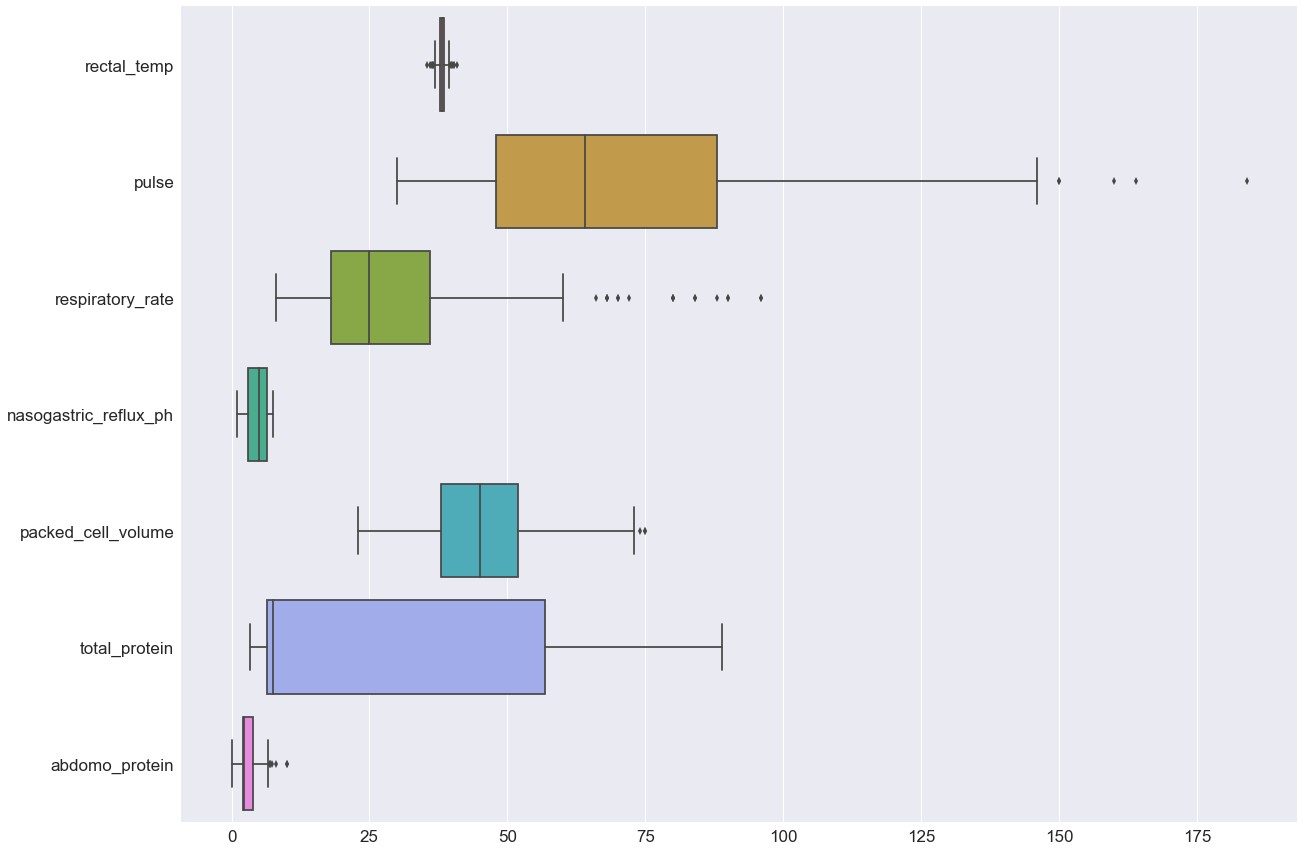

In [15]:
sns.set(font_scale=1.7)
sns.boxplot(data=X_numeric, orient='h');

Построим диаграммы рассеяния попарного взаимодействия признаков по классам

In [16]:
numeric_features_product = list(itertools.product(X_numeric.columns, X_numeric.columns))
unique_numeric_features_product = list()
for i in range(X_numeric.shape[1]):
    for j in range(X_numeric.shape[1]):
        if (i > j):
            unique_numeric_features_product.append(numeric_features_product[i * X_numeric.shape[1] + j])

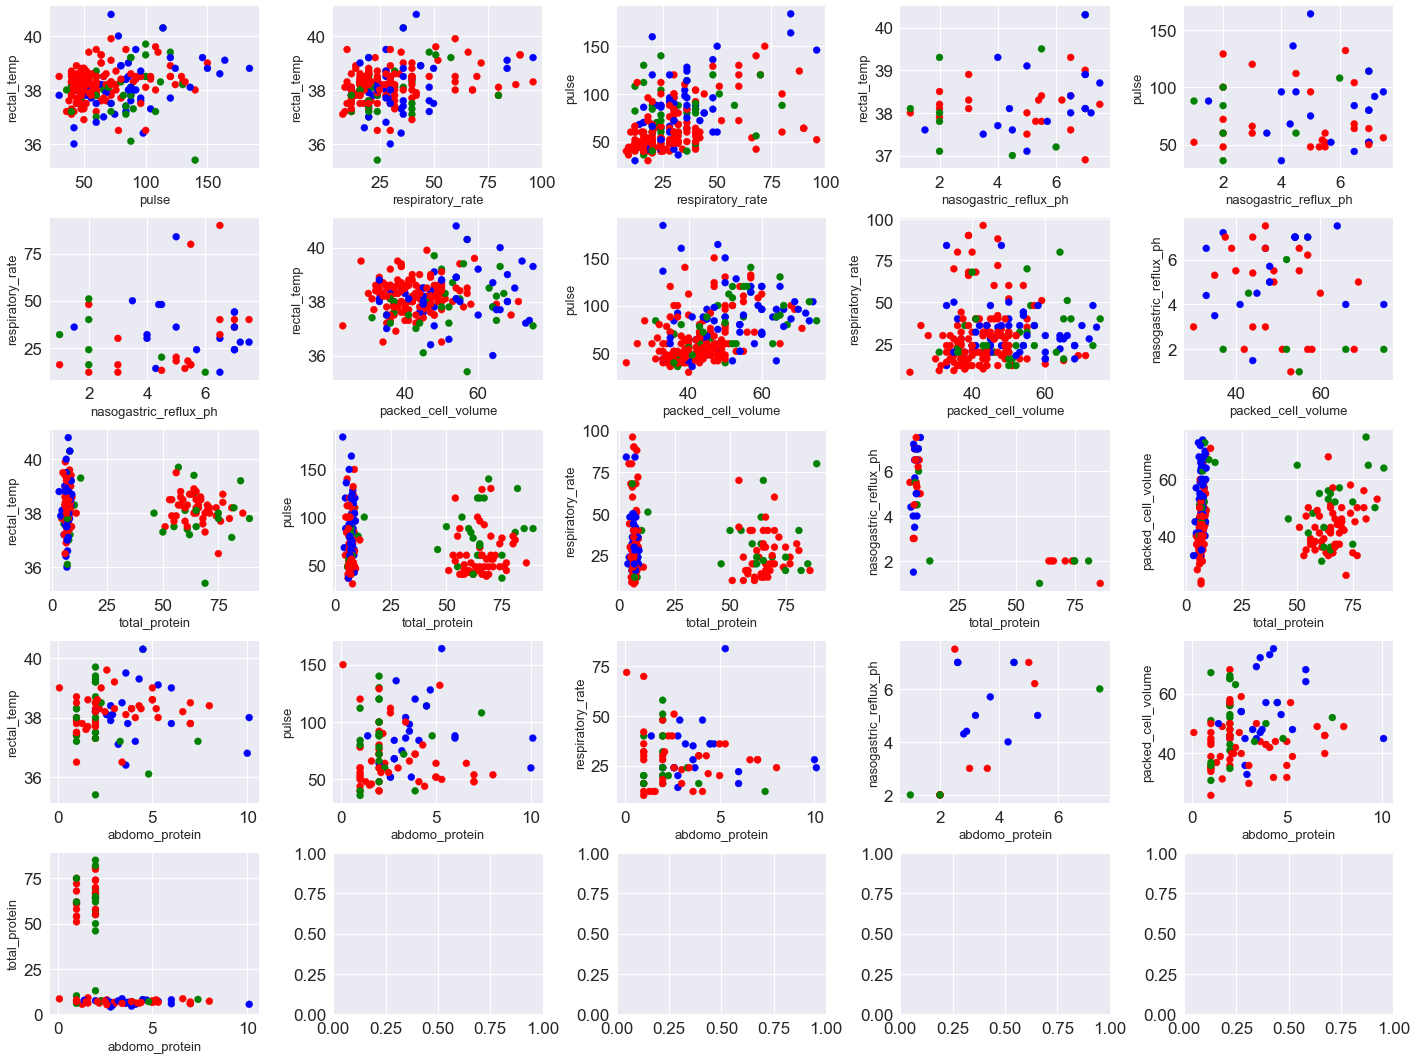

In [17]:
f, axarr = plt.subplots(5, 5)
f.tight_layout() 
colors = X_numeric_y['outcome'].map({'lived':'r', 'died':'b', 'euthanized':'g'})

for i in range(5):
    for j in range(5):
        pair_features = unique_numeric_features_product[5*i + j]      
        axarr[i, j].scatter(X_numeric_y[pair_features[0]], X_numeric_y[pair_features[1]], c=colors)
        axarr[i, j].set_xlabel(pair_features[0], fontsize=13)
        axarr[i, j].set_ylabel(pair_features[1], fontsize=13)
        if ((i==4) and (j==0)):
            break

#sns.set(font_scale=1)
#subplot_position = 0
#for pair_features in unique_numeric_features_product:
#    pair_columns = X_numeric[[pair_features[0], pair_features[1]]]
#    pair_columns = pair_columns.dropna()
#    subplot_position += 1
#    plt.subplot(5, 5, subplot_position)
#    sns.regplot(x=pair_features[0], y=pair_features[1], data=pair_columns)

На глаз можно заметить небольшую корреляцию в некоторых признаках. Например pulse-respiratory_rate имеют вполне естественное объяснение, чем больше пульс, тем чаще частота дыхания. Или зависимость pulse-packed_cell_volume, объясняющаяся увеличением скорости кровтока в зависимости от пульса. Но так же есть те, где я затрудняюсь объяснить взаимосвязь, например total_protein с остальным признаками, который неплохо отделяет died от euthanized.

В итоге, можно приметить пару кандидатов на формирование новых признаков, но сначала стоит убедиться в этом с помощью корреляции.

Строить корреляцию с целевым признаком, являющимся категорией, не будем, это бессмысленно. А вот для остальных посроим корреляцию Спирмена, так как корреляцию Пирсона стоит использовать для нормальных распределений, коих у нас не наблюдается. Кроме того Спирмен устойчив к выбросам и нелинейным зависимостям.

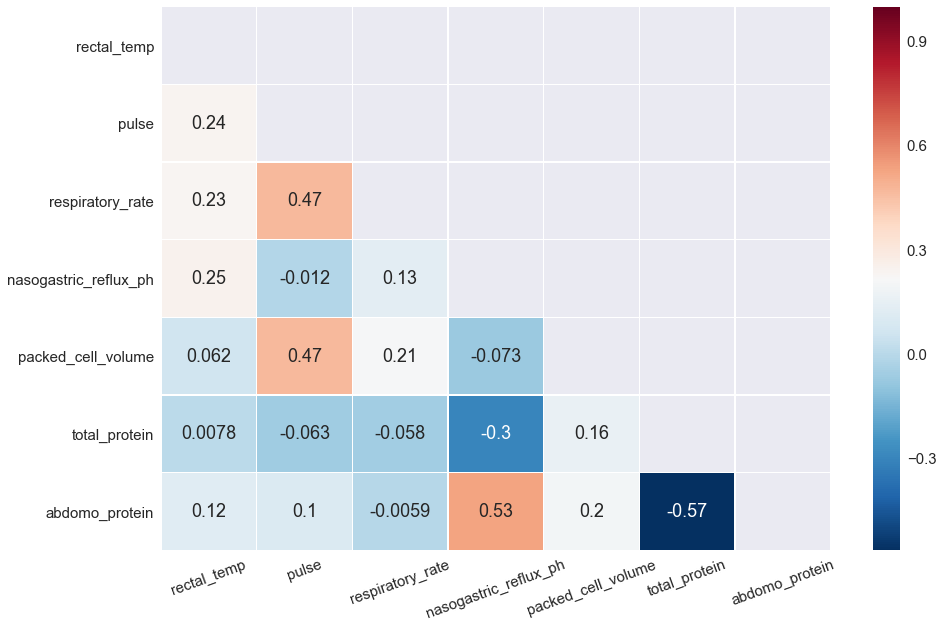

In [18]:
rcParams['figure.figsize'] = 15, 10
sns.set(font_scale=1.5)
import numpy as np

mask = np.zeros_like(X_numeric.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X_numeric.corr(method='spearman'), annot=True, linewidths=.5, mask=mask, cmap='RdBu_r');
plt.xticks(rotation=20);

Все те же кандидаты, стоит попробовать построить на их основе новые признаки, так как в их пространстве объекты неплохо разделяются. Также стоит применить PCA abdomo_protein-total_protein, сформировав новый признак и убрав высокую скоррелированность одной природы.

Далее взглянем на зависимость количественных признаков от целевой переменной. Так как корреляции Пирсона и Спирмена между ними по своей сути бессмысленна. Посмотрим на среднее по классам для каждого признака, это даст легко интерпретируемые результаты.

In [19]:
X_numeric_y.groupby('outcome').mean()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
outcome,,,,,,,
died,38.179245,87.227273,33.034483,5.430000,52.536232,6.844615,4.154167
euthanized,38.052941,81.744186,31.138889,3.555556,50.777778,42.038889,2.368000
lived,38.190789,63.421687,29.278912,4.537500,42.727273,27.264848,2.848077


По итогу есть явный аутсайдер, rectal_temp скорее всего не поможет в классификации, чего не скажешь о pulse и total_protein. Остальные кажутся также полезными, но в меньшей степени. rectal_temp скорее всего выкинем из модели.

На этом анализ количественных признаков подошел к концу, перейдем к категориальным

## Анализ категориальных признаков

Посмотрим на категориальные признаки со стороны. Видим опять большое количество пропусков, а также три признака lesion_1, lesion_2, lesion_3, которые на данный момент являются числовыми. Они состоят из 4 цифр, характеризующие полученные травмы, по категориям. Что это за категории есть описание выше.

In [20]:
X_categorial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 20 columns):
abdomen                  181 non-null object
abdominal_distention     243 non-null object
abdomo_appearance        134 non-null object
age                      299 non-null object
capillary_refill_time    267 non-null object
cp_data                  299 non-null object
hospital_number          299 non-null int64
lesion_1                 299 non-null int64
lesion_2                 299 non-null int64
lesion_3                 299 non-null int64
mucous_membrane          252 non-null object
nasogastric_reflux       193 non-null object
nasogastric_tube         195 non-null object
pain                     244 non-null object
peripheral_pulse         230 non-null object
peristalsis              255 non-null object
rectal_exam_feces        197 non-null object
surgery                  299 non-null object
surgical_lesion          299 non-null object
temp_of_extremities      243 non-null object

 На данный момент я исключу их из анализа, потому что им нужная особая предобработка, вернемся к ним позже

In [21]:
X_categorial_y = X_categorial.copy()
X_categorial_y['outcome'] = y
X_categorial_y_without_lesions = X_categorial_y[X_categorial_y.columns.difference(['lesion_1', 'lesion_2', 'lesion_3'])]

Для каждого оставшегося признака построим factorplotы в зависимости от класса, так мы визуально узнаем что там за категории и в каком они соотношении

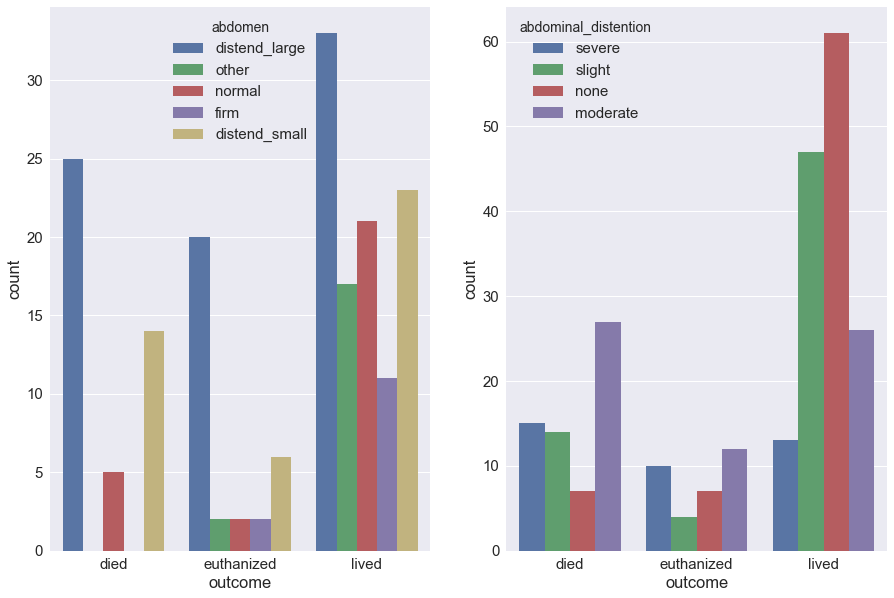

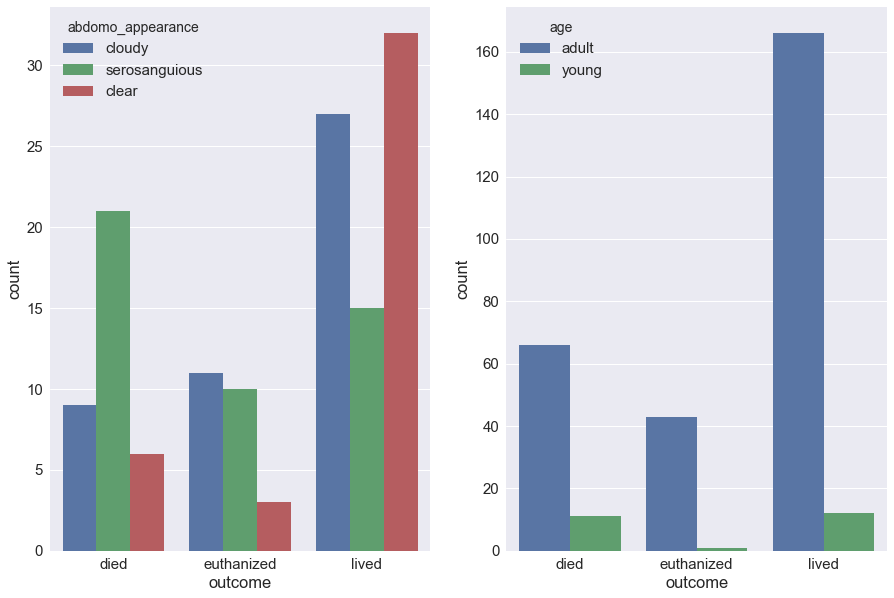

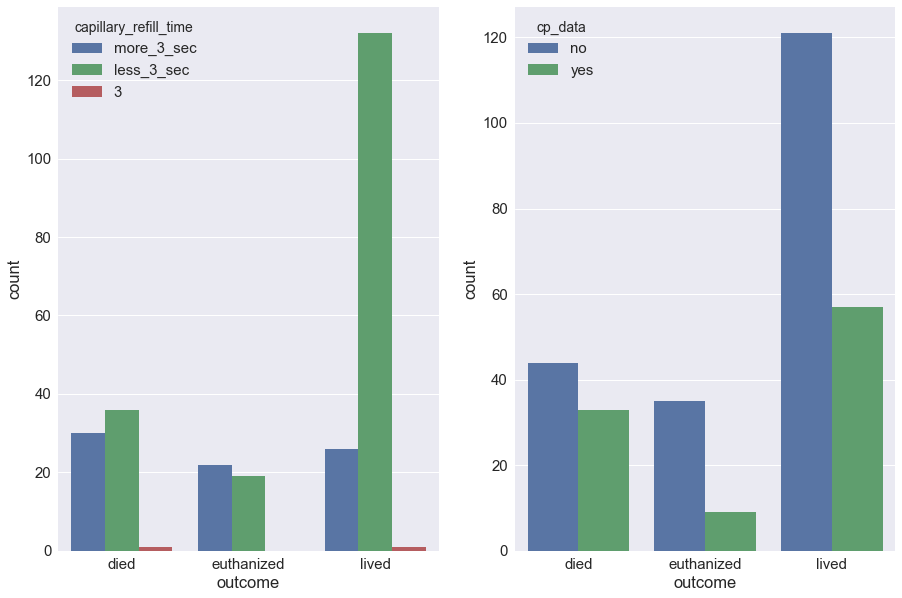

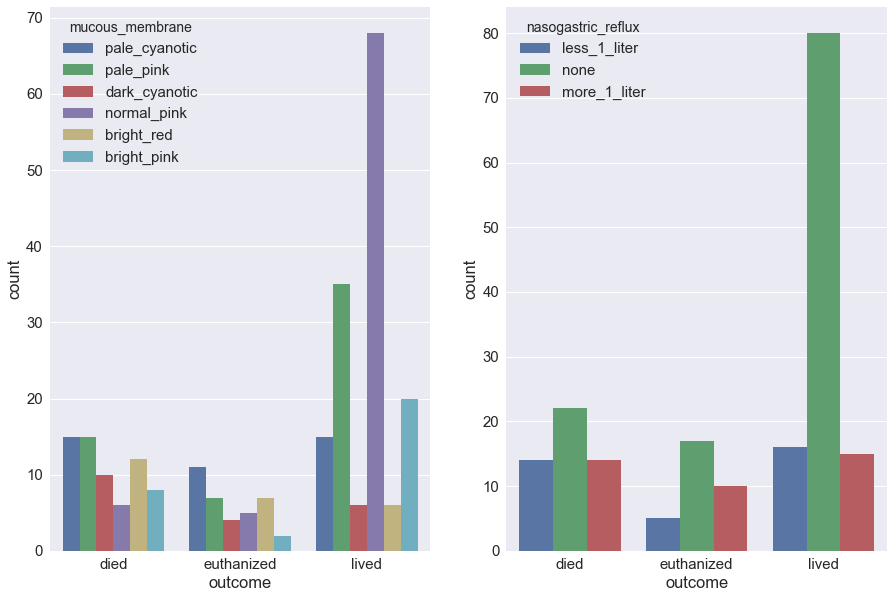

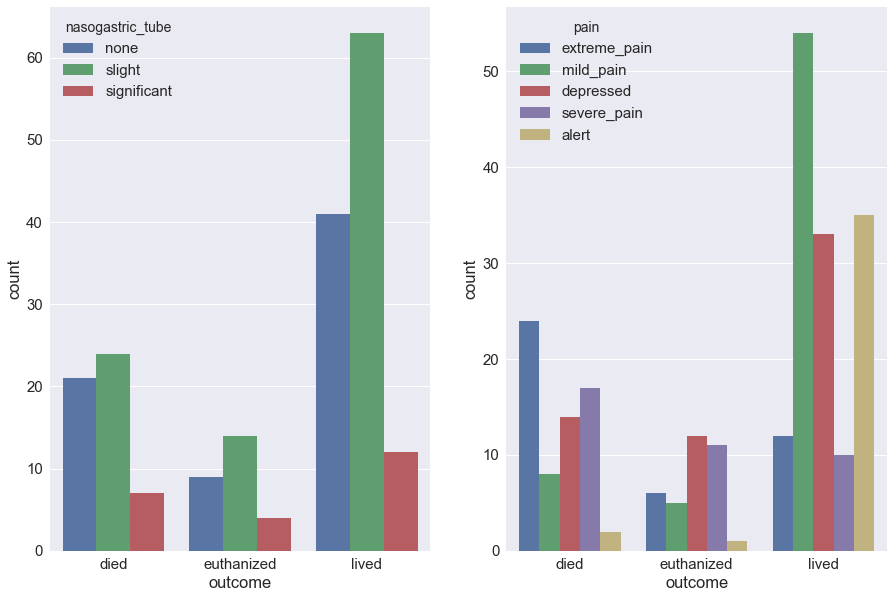

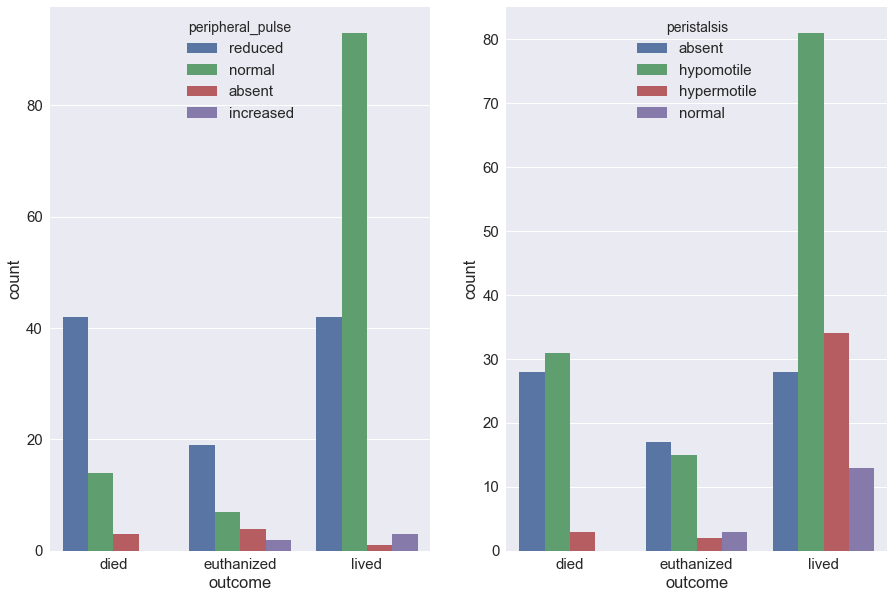

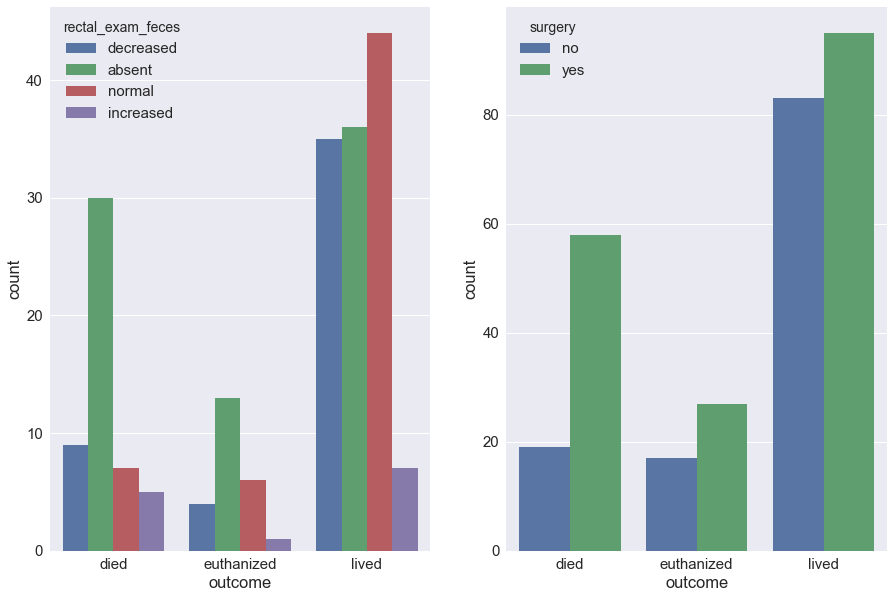

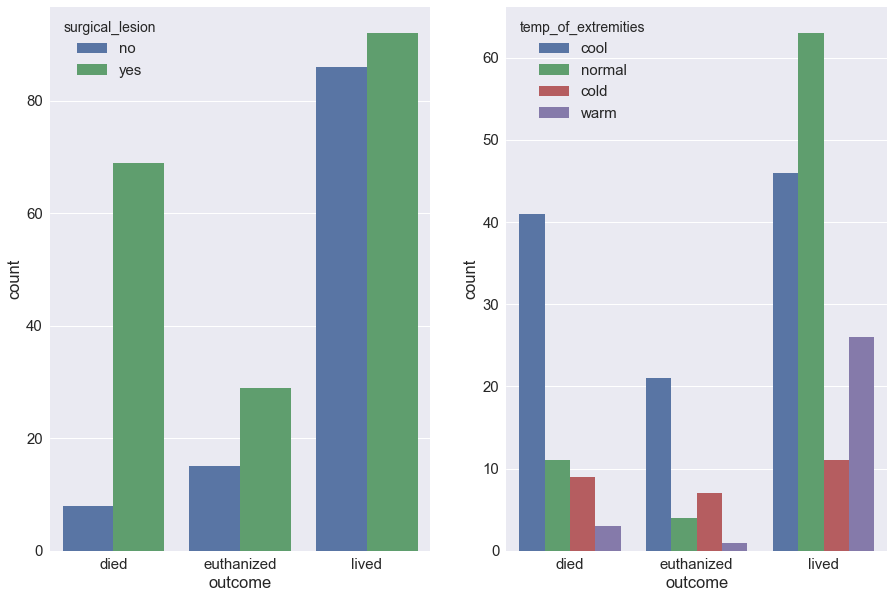

In [22]:
factorplot_columns = X_categorial_y_without_lesions.columns.difference(['outcome', 'hospital_number'])
for i in range(0, 16, 2):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    g=sns.factorplot(x='outcome', hue=factorplot_columns[i], data=X_categorial_y_without_lesions, kind='count', ax=ax1);
    g1=sns.factorplot(x='outcome', hue=factorplot_columns[i+1], data=X_categorial_y_without_lesions, kind='count', ax=ax2);
    plt.close(g.fig)
    plt.close(g1.fig)
    plt.show()

Окинунов рисунки взглядом, можно уже сейчас заметить некоторые зависимости от целевой переменной. Например взрослые лошади чаще выживают, чем молодые и т.д. Но здесь рисунки представлены больше для ознакомпления с категорями, нежели для проводения анализа с целевой переменной. Кроме того, здесь можно найти кандидатов на объединение, где частота категории мала по сравнению с другими. Я нашел только одну такую, "3" в capillary_refill_time, но наверное лучше стоит это делать основываясь на статистике, а не "на глаз".

Давайте взглядом посмотри на каждый категориальный признак в зависимости от целевой переменной, это будет долго)

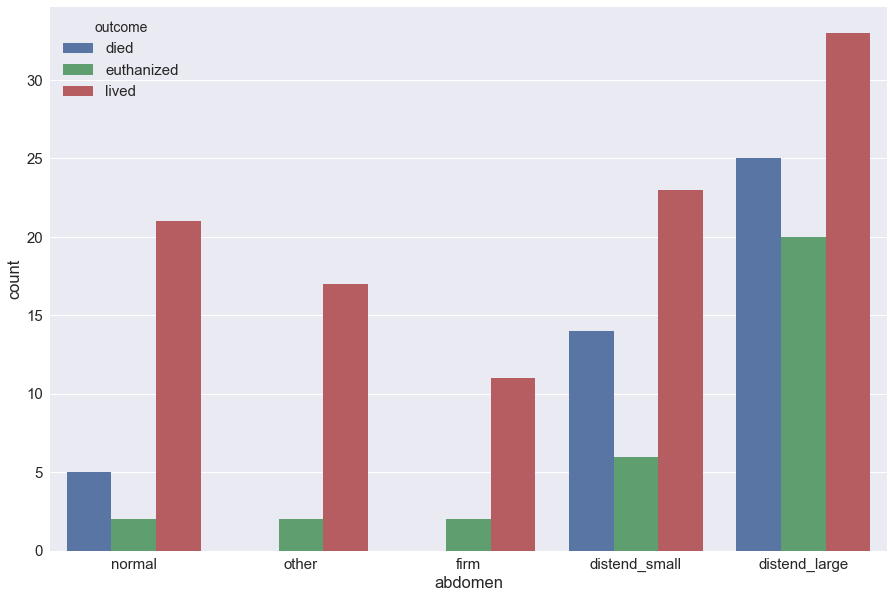

In [23]:
sns.countplot(x='abdomen', hue='outcome', data=X_categorial_y_without_lesions, 
              order=['normal', 'other', 'firm', 'distend_small', 'distend_large']);

Первым идет abdomen, который описывает состояние кишечника. В информации о нем написано, что на крайних стадиях distend_small и distend_large требуется хирургическое вмешательство и как раз на этих же стадиях резко ворзрастает процент умерших и усыпленных лошадей. Совпадение? Я так не думаю.

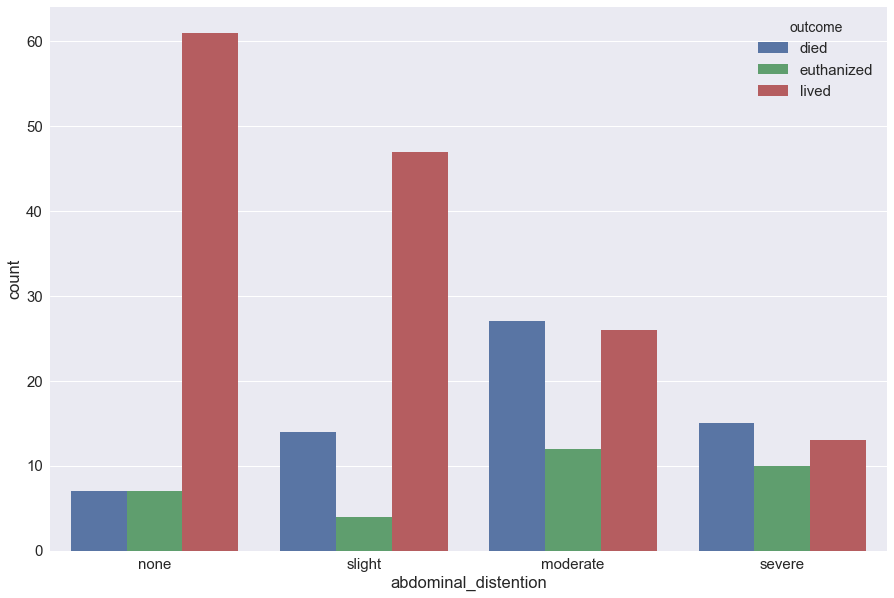

In [24]:
sns.countplot(x='abdominal_distention', hue='outcome', data=X_categorial_y_without_lesions,
              order=['none', 'slight', 'moderate', 'severe']);

Второй признак на очереди abdominal_distention, который характеризует степень метеоризма. Также как и в предыдущем, две последние стадии требуют хирургического вмешательства и опять именно на них возрастает процент погибших лошадей, кроме того, количество погибших начинает превышать количество выживших.

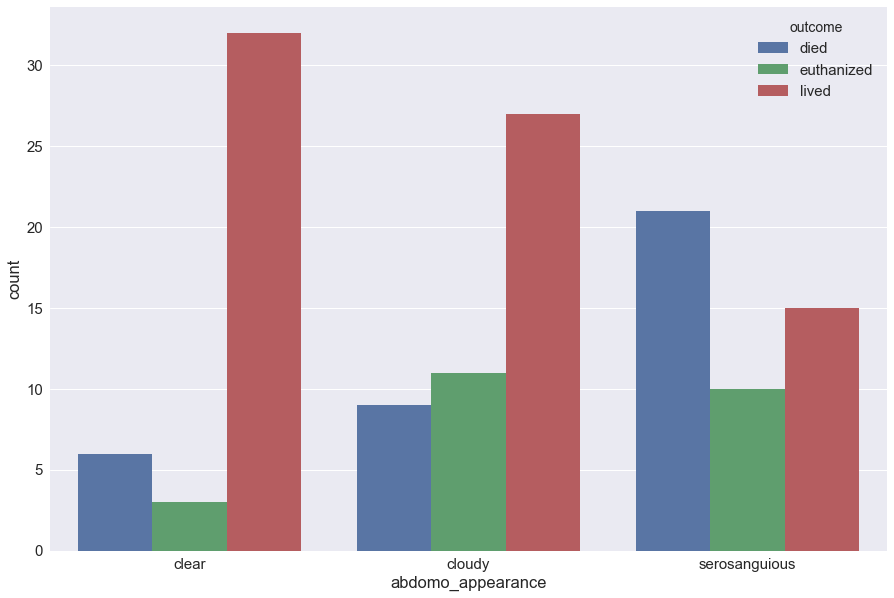

In [25]:
sns.countplot(x='abdomo_appearance', hue='outcome', data=X_categorial_y_without_lesions,
              order=['clear', 'cloudy', 'serosanguious']);

abdomo_appearance - третий признак имеющий отношение к брюшной полости. Не силен в медицине, но ветеринары с помощью шприца получают какую-то жидкость из брюшой полости и смотрят на её "внешний вид". Если она чистая, то все хорошо, иначе проблемы. В данном случае процент погибших лошадок плавно увеличивается, а на последней стадии и вовсе превосходит количество выживших.

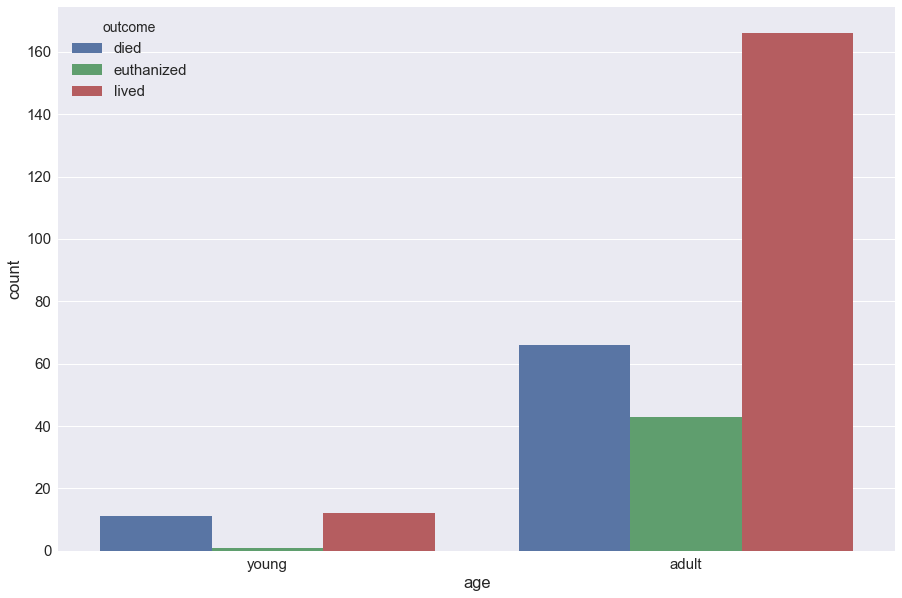

In [26]:
sns.countplot(x='age', hue='outcome', data=X_categorial_y_without_lesions,
              order=['young', 'adult']);

Тут все просто, это возраст лошади. Сильно бросатеся в глаза то, что взрослые выживаю гораздо чаще, чем умирают. Видимо это связано с тем, что до 6 мясецев у лошадей организм еще слишком слабый.

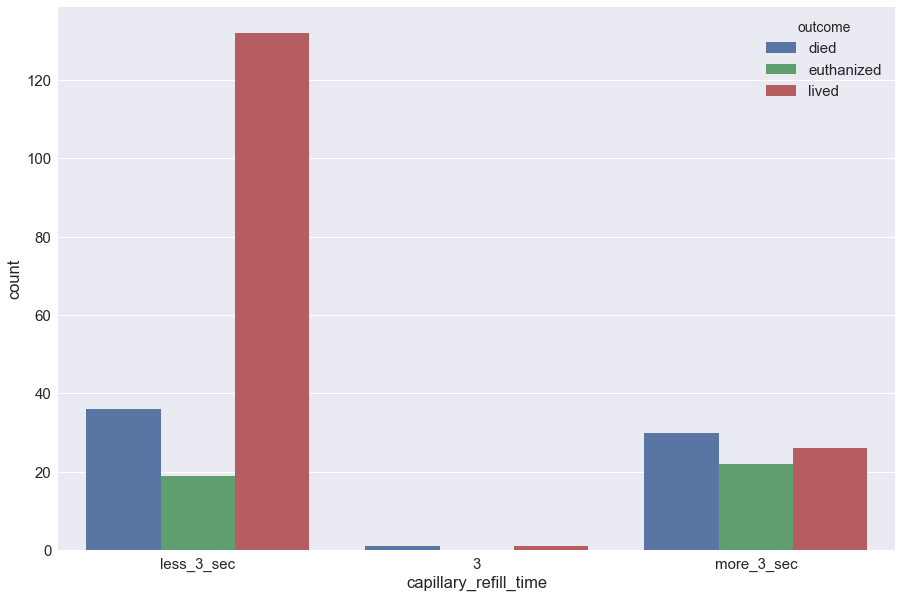

In [27]:
sns.countplot(x='capillary_refill_time', hue='outcome', data=X_categorial_y_without_lesions,
              order=['less_3_sec', '3', 'more_3_sec']);

Этот признак дословно можно перевести как "время заполнения каппиляра". Где, как и что замеряют не понятно, но он имеет достаточно ясный смысл: чем меньше время заполения, тем более здоровая кровь. Видно что при more_3_sec, количество смертей превышает количество выживших.

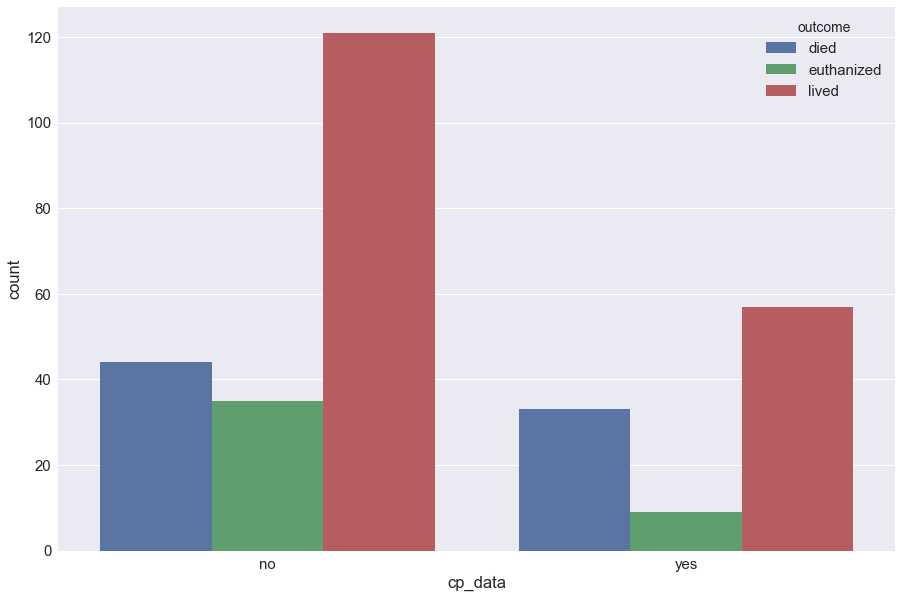

In [28]:
sns.countplot(x='cp_data', hue='outcome', data=X_categorial_y_without_lesions);

Признак патологии, первый кандидат, который стоит выкинуть из рассмотрения. Ничего осмысленнго по нему сказать нельзя, отсюда видно только то, что лошадей без паталогий больше.

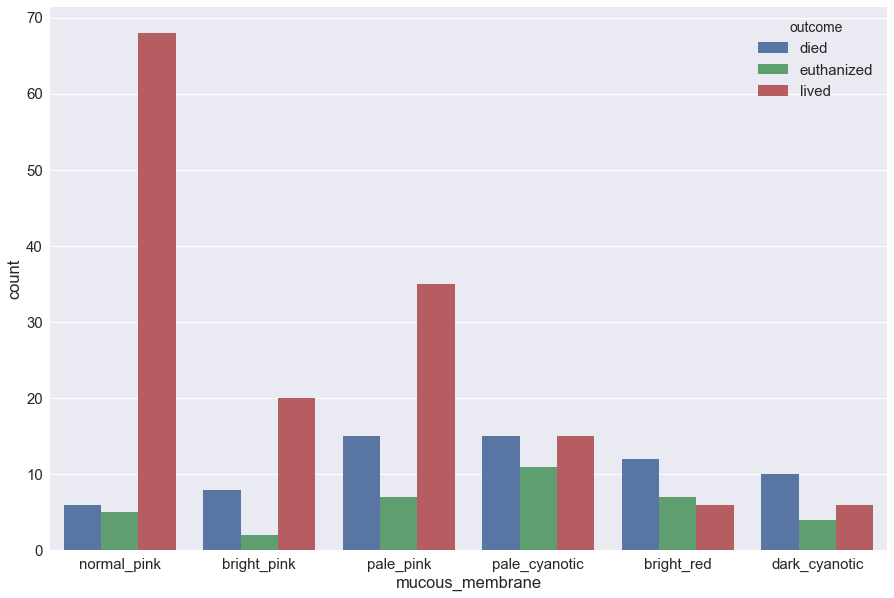

In [29]:
sns.countplot(x='mucous_membrane', hue='outcome', data=X_categorial_y_without_lesions,
              order=['normal_pink', 'bright_pink', 'pale_pink', 'pale_cyanotic', 'bright_red', 'dark_cyanotic']);

Это визуальная оценка цвета слизистой, которая говорит о состоянии крови. Последние 3 стадии характеризуют серьезное нарушение кровообращения, а bright_red к тому же говорит об инфицировании. Именно на 3 последних стадиях смертность превышает выживаемость, а шансы лошади резко падают.

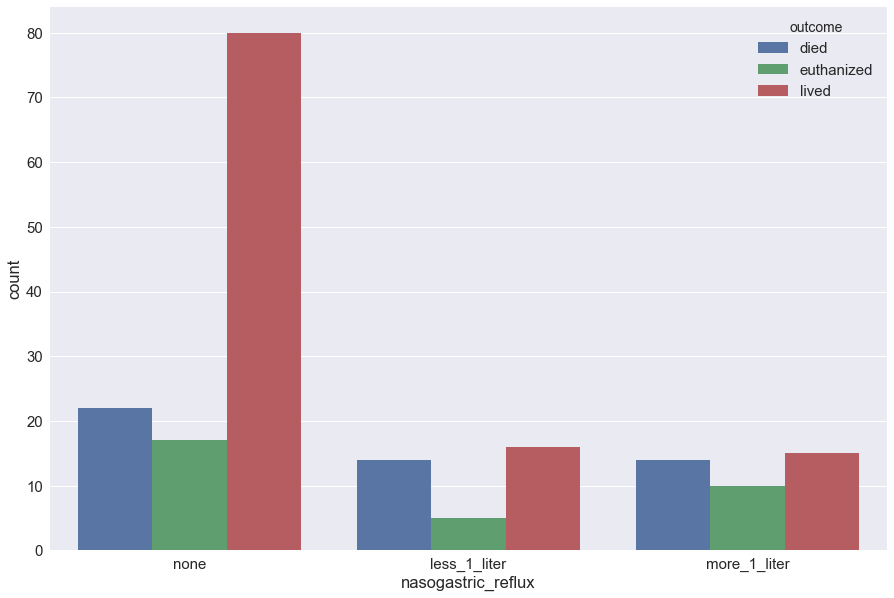

In [30]:
sns.countplot(x='nasogastric_reflux', hue='outcome', data=X_categorial_y_without_lesions,
              order=['none', 'less_1_liter', 'more_1_liter']);

Признак рвоты или соплей, если честно сам понять до конца не могу, но он достаточно легко интепретируется: если есть хоть какое-то количество жидкости, неважно, больше или меньше литра, то шансы выжить сразу же падают. Грубо говоря, можно создать новый признак, вообще наличия обратного тока соплей/рвоты.

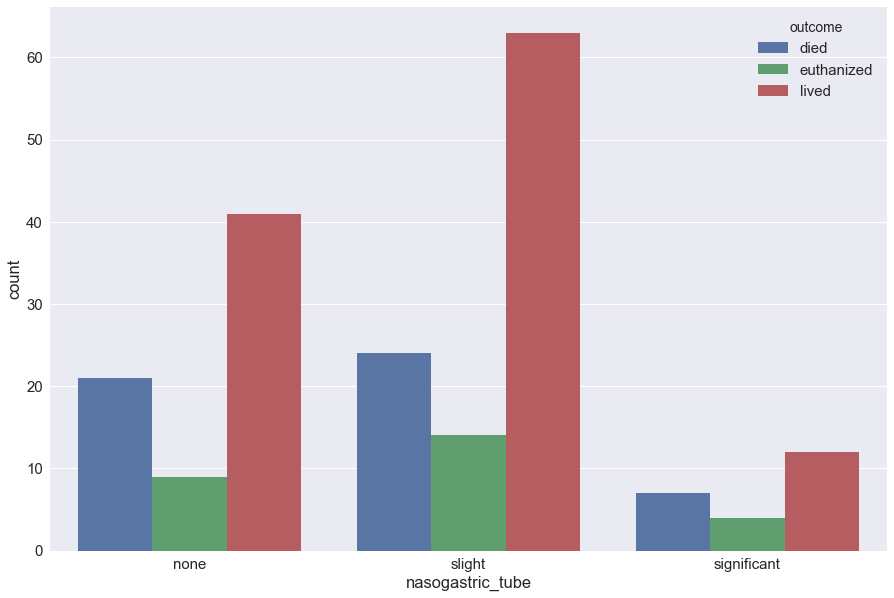

In [31]:
sns.countplot(x='nasogastric_tube', hue='outcome', data=X_categorial_y_without_lesions);

Таже история, непонятно что это за медицинский термин, но он также легко интерпритируется. Характеризует степени значительности, чем более значителен признак, тем больше шансов быть мертвым. Вот так.

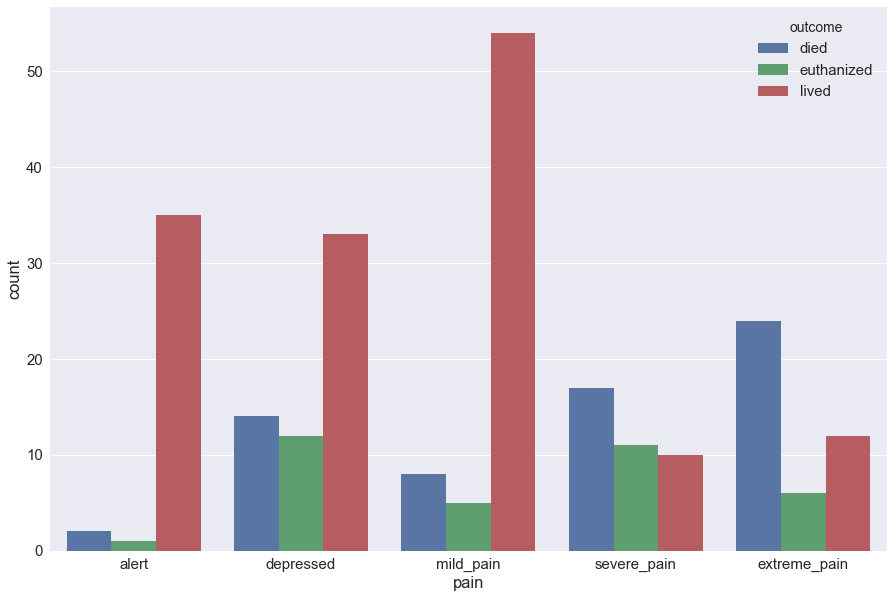

In [32]:
sns.countplot(x='pain', hue='outcome', data=X_categorial_y_without_lesions,
              order=['alert', 'depressed', 'mild_pain', 'severe_pain', 'extreme_pain']);

Субъективная оцнека боли лошади. Кажется, что он должен быть достаточно показательным и действительно, чем сильнее боль, которую ощущает лошадь, тем больше шансов на смерть

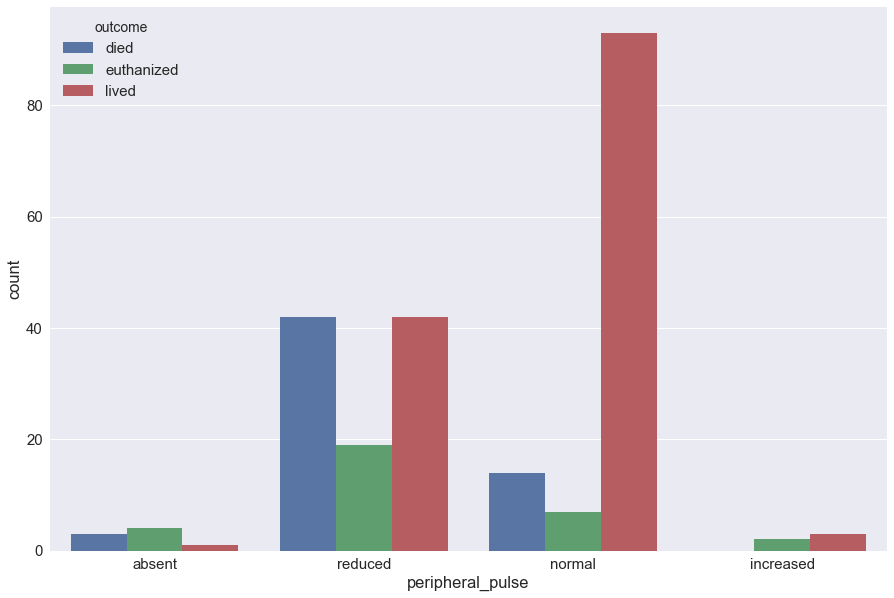

In [33]:
sns.countplot(x='peripheral_pulse', hue='outcome', data=X_categorial_y_without_lesions,
              order=['absent', 'reduced', 'normal', 'increased']);

Замер пульса, видимо по какой-то вене, как у человека на запястье. Повышенный пульс редко регестрируют, так же редко не могут прощупать пульс. В случае пониженного пульса характерно то, что увеличивается смертность, возможно показывает медленное угасание организма.

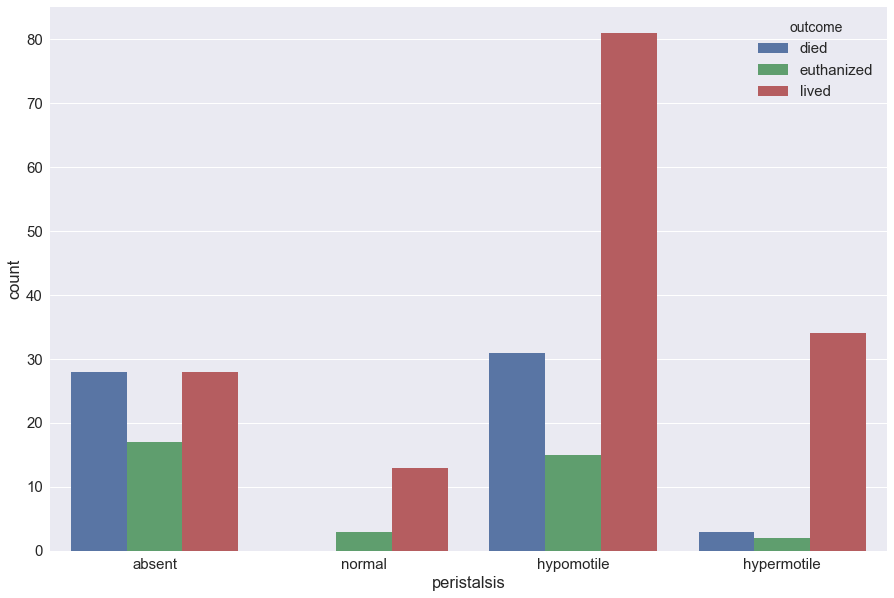

In [34]:
sns.countplot(x='peristalsis', hue='outcome', data=X_categorial_y_without_lesions,
              order=['absent', 'normal', 'hypomotile', 'hypermotile']);

Осталось немного, еще чуть-чуть) Тут сложно понять, что вообще значат эти категории признака "сократимость", но при отсутствии сократимости, шансы выжить становятся 50 на 50, в остальных случаях лошади в основном выживают

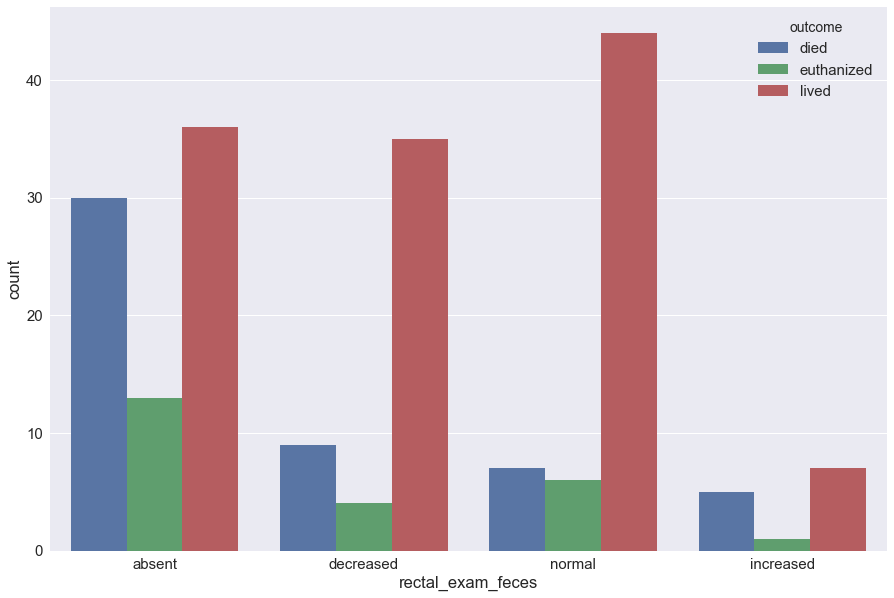

In [35]:
sns.countplot(x='rectal_exam_feces', hue='outcome', data=X_categorial_y_without_lesions,
              order=['absent', 'decreased', 'normal', 'increased']);

Здесь у нас ректальное обследование фекалий, дословно показывает их "количество". При отсутсвии или повышении фикалий шансы выжить по сравнению со смертью сильно уменьшаются, что ясно указывает на проблемы с кишечником

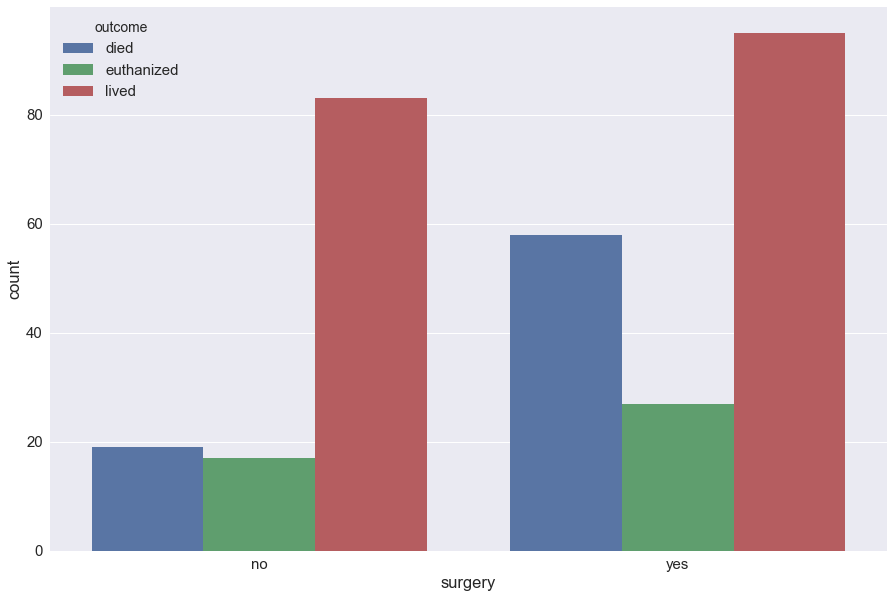

In [36]:
sns.countplot(x='surgery', hue='outcome', data=X_categorial_y_without_lesions);

surgery показывает было ли у лошади в прошлом хирургическо вмешательство. Не трудно заметить, что наличие такого повышает шансы смерти, видимо операция все ухудшает в долгосрочной преспективе.

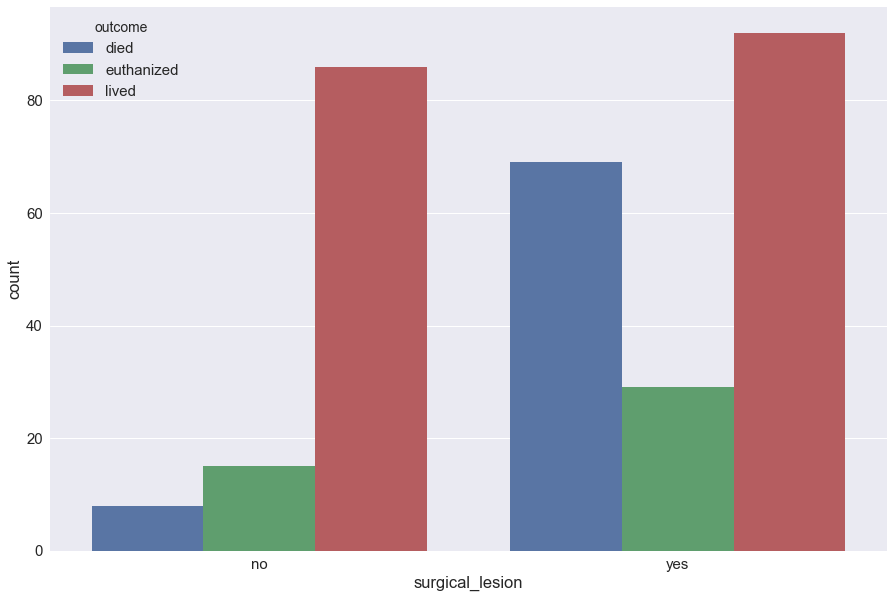

In [37]:
sns.countplot(x='surgical_lesion', hue='outcome', data=X_categorial_y_without_lesions);

Схожый признак, но показывает наличие травмы при хирургческом вмешательстве. В целом аналогичная ситуация с предыдущим.

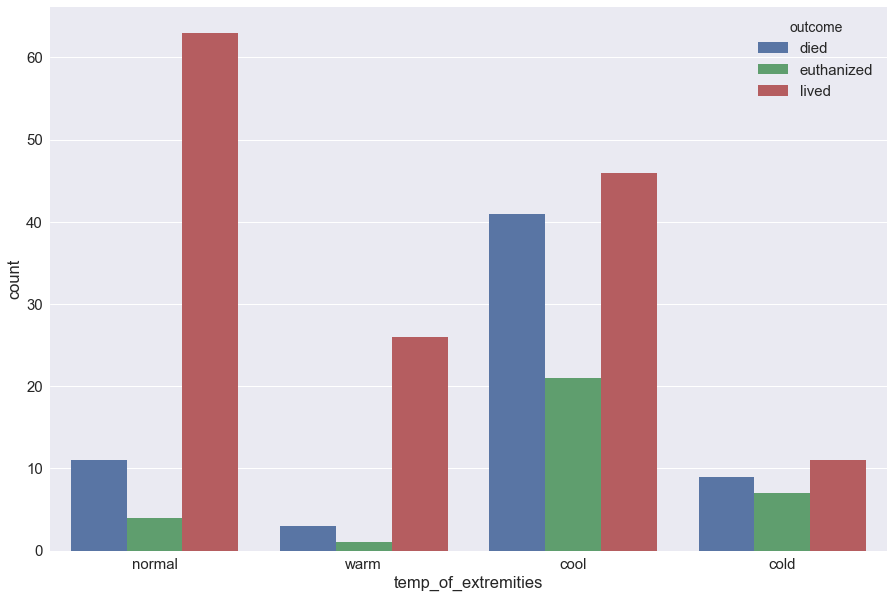

In [38]:
sns.countplot(x='temp_of_extremities', hue='outcome', data=X_categorial_y_without_lesions,
              order=['normal', 'warm', 'cool', 'cold']);

Наконец последний категориальный признак - температура конченостей. Если коротко, то при прохладных и холодных конечностях повышаются шансы смерти, характеризует проблемы с кровообращением

Как говорилось выше, корреляция Пирсона и Спирмена для категориальных и бинарных признаков бесмысленна. Значит нужно использовать более подходящий коэффициент, таковым например является коэффициент Крамера или коэффициент Мэтьюса для бинарных. На самом деле есть еще куча всяких, советую хотя бы узнать какие есть. Построим матрицу аналогичную корреляционной и посмотрим, что у нас получилось.

In [39]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

categorial_cramers = np.zeros((X_categorial_y_without_lesions.shape[1], X_categorial_y_without_lesions.shape[1]))

for i in range(len(X_categorial_y_without_lesions.columns)):
    for j in range(len(X_categorial_y_without_lesions.columns)):
        
        confusion_matrix = pd.crosstab(X_categorial_y_without_lesions[X_categorial_y_without_lesions.columns[i]],
                                       X_categorial_y_without_lesions[X_categorial_y_without_lesions.columns[j]])
        categorial_cramers[i, j] = cramers_corrected_stat(confusion_matrix)

categorial_cramers = pd.DataFrame(categorial_cramers)
categorial_cramers.columns = X_categorial_y_without_lesions.columns
categorial_cramers.index = X_categorial_y_without_lesions.columns

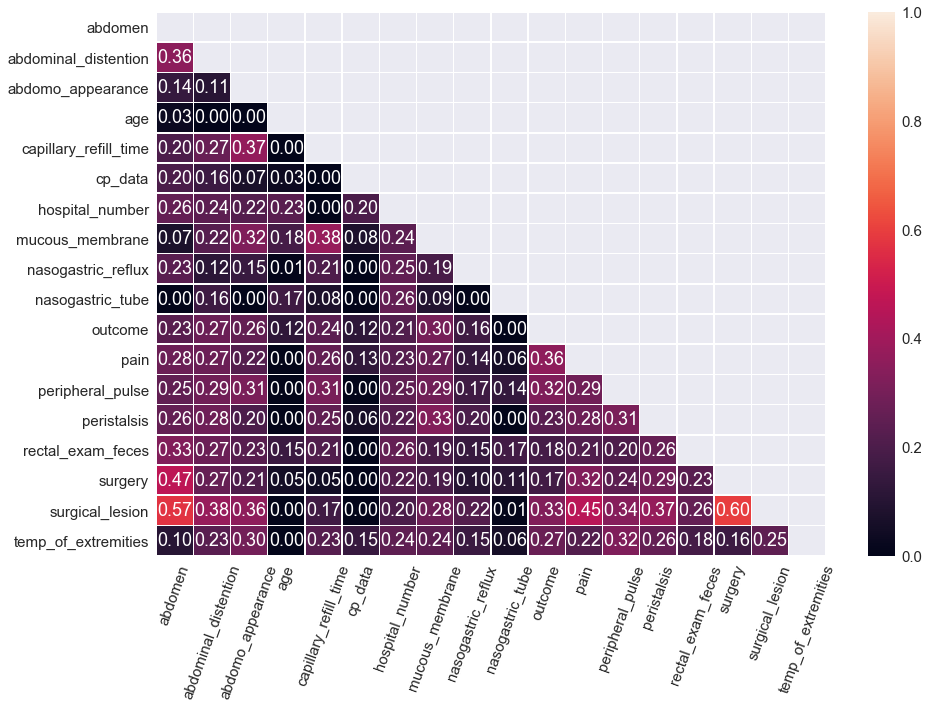

In [40]:
mask = np.zeros_like(categorial_cramers)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(categorial_cramers, annot=True, linewidths=.5, mask=mask, fmt='.2f');
plt.xticks(rotation=70);

А получилось неплохо и хорошо согласуется с визуальным анализом. cp_data - outcome получил самый низкий коэффициент, о чем собственно мы и говорили.

Давайте посмотрим на межкатегориальное взаимодействие признаков, но спешу вас успокоить, посмотрим лишь самые интересные случаи, в соответствии с корреляционной матрицей.

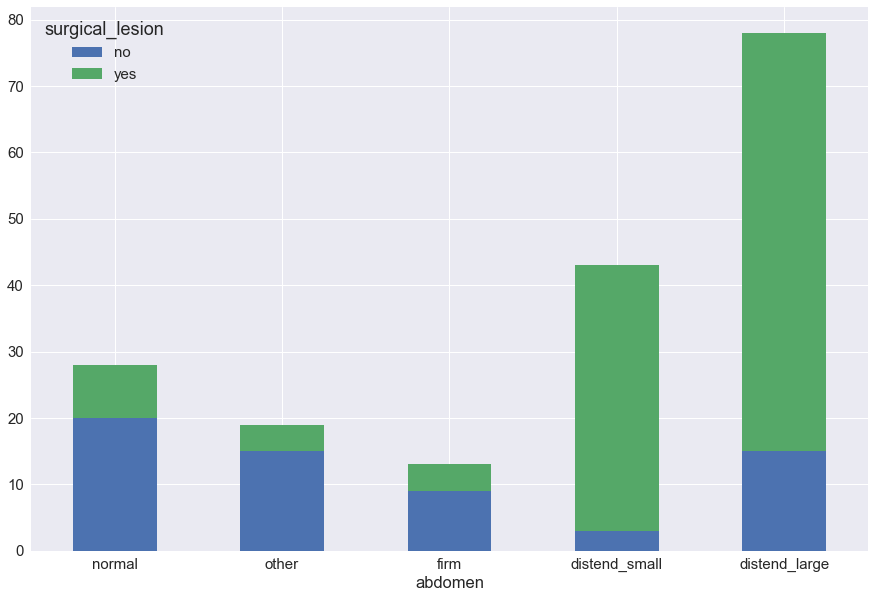

In [41]:
ct = pd.crosstab(X_categorial['abdomen'], X_categorial['surgical_lesion'])
ct = ct.loc[['normal', 'other', 'firm', 'distend_small', 'distend_large'], :]
ct.plot.bar(stacked=True);
plt.xticks(rotation=0);

Взимосвзяь состояния кишечника и травмы после хирургического вмешательства. Видно, что два самых тяжелых состояния кишечника в большинстве случаев проиходят из-за травм во время операции

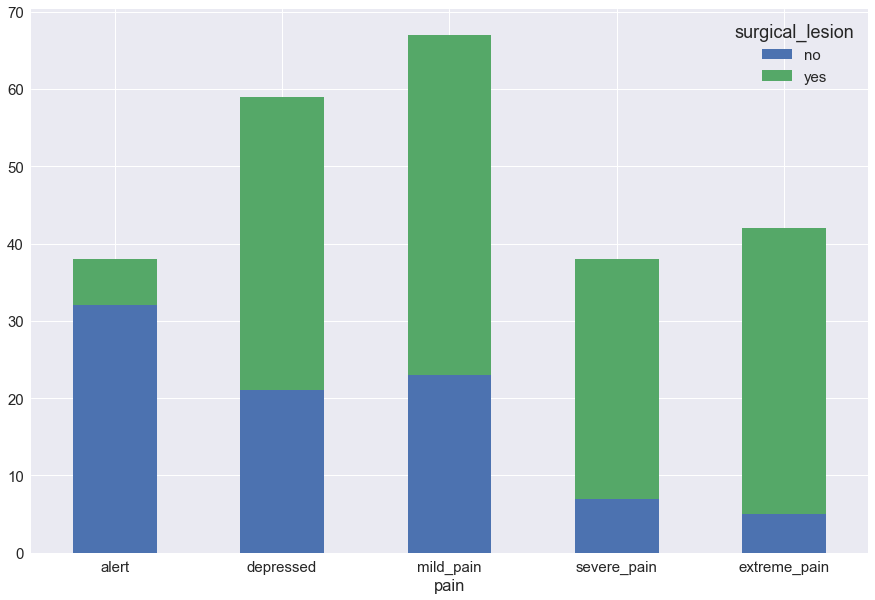

In [42]:
ct = pd.crosstab(X_categorial['pain'], X_categorial['surgical_lesion'])
ct = ct.loc[['alert', 'depressed', 'mild_pain', 'severe_pain', 'extreme_pain'], :]
ct.plot.bar(stacked=True);
plt.xticks(rotation=0);

Здесь у нас взаимодействие субъективной оценки боли и трамы после операции. Таже картина, лошадь испытывает сильные боли, при наличинии травм во время операции. По всей видимости врачам нужно быть аккуратней

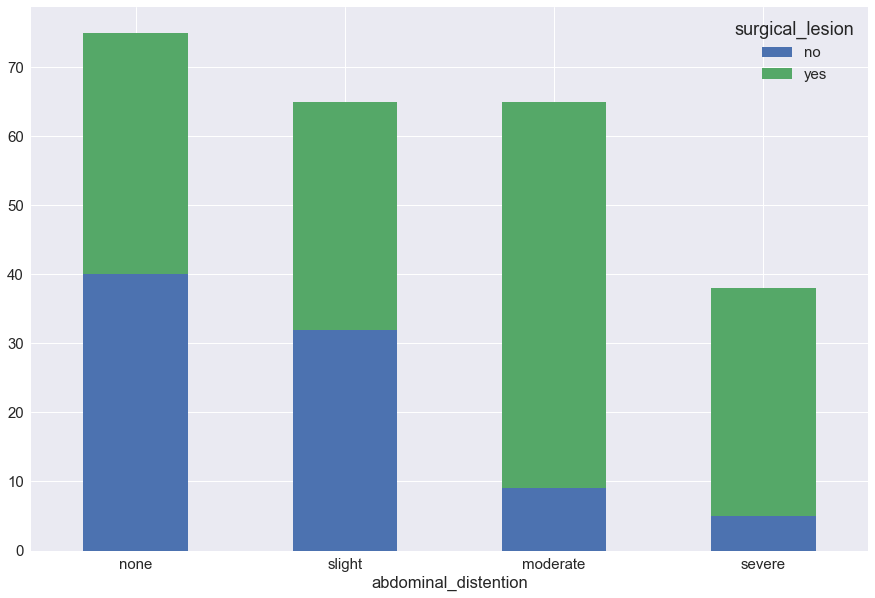

In [43]:
ct = pd.crosstab(X_categorial['abdominal_distention'], X_categorial['surgical_lesion'])
ct = ct.loc[['none', 'slight', 'moderate', 'severe'], :]
ct.plot.bar(stacked=True);
plt.xticks(rotation=0);

И тут все таже травма после операции и вздутие живота. Опять тоже самое, хирургическоя травма приводит к последущим проблемам с животом. Врачам точно стоит быть поаккуратней

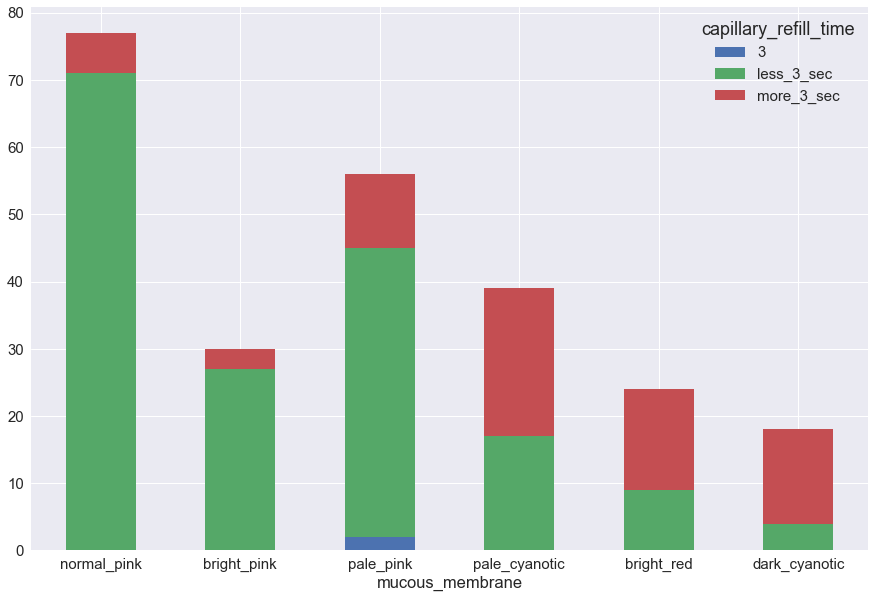

In [44]:
ct = pd.crosstab(X_categorial['mucous_membrane'], X_categorial['capillary_refill_time'])
ct = ct.loc[['normal_pink', 'bright_pink', 'pale_pink', 'pale_cyanotic', 'bright_red', 'dark_cyanotic'], :]
ct.plot.bar(stacked=True);
plt.xticks(rotation=0);

Как я отметил ранее, цвет слизистой говорит о состянии крови и кровообращения. В данном случае при нарушениях кровообращения наблюдается загустевание крови, что впринципе логично.

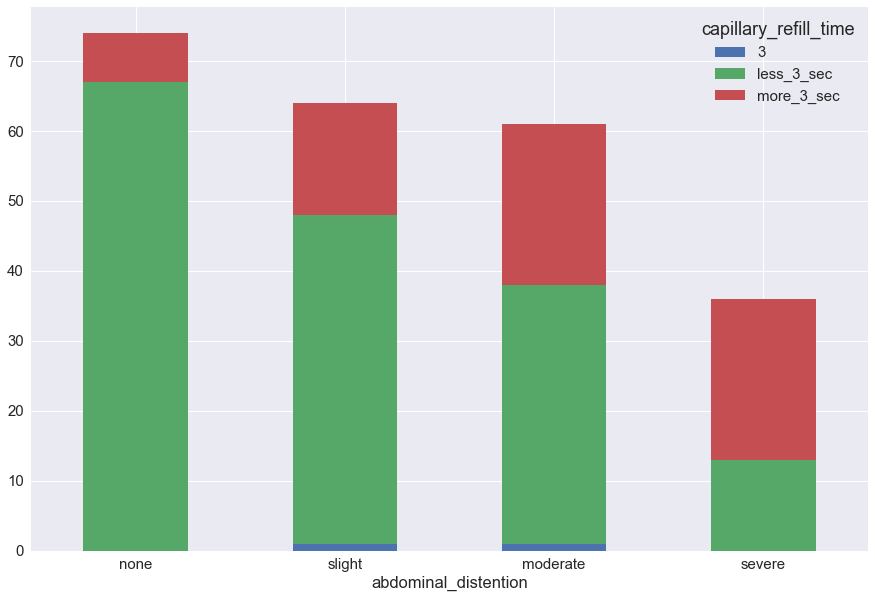

In [45]:
ct = pd.crosstab(X_categorial['abdominal_distention'], X_categorial['capillary_refill_time'])
ct = ct.loc[['none', 'slight', 'moderate', 'severe'], :]
ct.plot.bar(stacked=True);
plt.xticks(rotation=0);

Здесь странная зависимость, чем больше раздут живот тем больше густеет кровь. Я затрудняюсь логически связать эти два факта вместе

На этом анализ категориальных признаков и в целом признаков подходит к концу. На самом деле стоило бы еще изучить взаимодействие категориальных и количественных признаков, но в данном случае это уже небольшой оверхед для текущей задачи и наверное больше пригодится в каггле или в реальном проекте.

## Выбор метрики и модели

Сначала касательно метрики, из анализа были сделаны выводы, что необходима метрика которая учитывает дизбаланс классов. Accuracy сразу же отметается из рассмотрения и остаются roc-auc, precision, recall и f-мера. Roc-auc не очень удобен в мультиклассовой классификации, да и оставшиеся метрики смотрятся более выгодно в свете медицинской задачи. Так как у нас задачи "предсказать" смерть, то соответсвенно нам необходимо определить как можно больше лошадей, которым требуется помощь. Precision просим на выход) Остается recall и f-мера. Просто recall не стоит использовать, так как нужна модель, которая не будет отправлять повально всех на операцию, важна хотя бы какая-то точность. Тут то и подходит f-мера, но слегка модифицированная. F beta, где коэффициент beta > 1 делает акцент на recall, но и не забывает про precision, а это именно то что нам нужно. Кроме того поставим average='micro', так как классы имеют для нас разную ценность и выделить died предпочтительней. С метрикой определились: fbeta(beta=2, average='micro')

Далее модель, есть пару вариантов: ближайшие соседи, линеные модели, деревянные модели и нейронный сети. Первый выбросим, так как в большинстве случаев метод ближайших соседей справляется хуже всех остальных. Последний вариант это как бить из пушки по воробьям, классические методы в таких задачах будут не хуже, а может даже и лучше. Остаются линейные и деревянные, но взглянув на данные, с таким количеством категориальных признаков сразу ясно кому стоит отдать предпочтение, а именно бустингу над деревьями. К тому же кого мы обманываем, это золотой молоток, если не знаешь, что делать, бери бустинг) Модель: lightgbm от Майкрософта.

## Создание бейзлайна

Сначала сделаем самый простой бейзлан, от которого уже будем плясать. Самое простое, что мы можем сделать, это спрогнозировать всем смерть и отправить на операцию, тогда мы точно не ошибемся.

In [46]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

_, X_numeric_test, _, y_test = train_test_split(X_numeric, y, test_size=0.25, random_state=7)
y_num = y_test.map({'lived':1, 'died':2, 'euthanized':3})
simple_predictions = np.full((y_num.shape), 2)

print('fbeta_score: {0}'.format(round(fbeta_score(y_num, simple_predictions, average='micro', beta=2), 2)))
print(classification_report(y_num, simple_predictions))

fbeta_score: 0.24
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        50
          2       0.24      1.00      0.39        18
          3       0.00      0.00      0.00         7

avg / total       0.06      0.24      0.09        75



Получилось 0.24 fbeta как стартовая точка, recall по классу died 100%, все спасены, но сделано это не рационально. Будем улучшать

Помните мы делали большой анализ данных, рисовали картинки, графики? Ну вот из них можно сделать руками самую простую модель для классификации, своебразное голосование над пеньками.

In [47]:
def predict(answers, thresholds, value):
    if value < thresholds[0]:
        return answers[0]
    elif thresholds[0] <= value < thresholds[1]:
        return answers[1]
    else:
        return answers[2]

baseline_num_predictions = pd.DataFrame()
baseline_num_predictions['pulse'] = X_numeric_test['pulse'].apply((lambda x: predict([1, 3, 2], [72.58, 84.48], x)))
baseline_num_predictions['resp_rate'] = X_numeric_test['respiratory_rate'].apply((lambda x: predict([1, 3, 2], [30.20, 32.08], x)))
baseline_num_predictions['reflux_ph'] = X_numeric_test['nasogastric_reflux_ph'].apply((lambda x: predict([3, 1, 2], [4.04, 4.98], x)))
baseline_num_predictions['cell_volume'] = X_numeric_test['packed_cell_volume'].apply((lambda x: predict([1, 3, 2], [46.75, 51.65], x)))
baseline_num_predictions['total_protein'] = X_numeric_test['total_protein'].apply((lambda x: predict([2, 1, 3], [17.05, 34.65], x)))
baseline_num_predictions['abdomo_protein'] = X_numeric_test['abdomo_protein'].apply((lambda x: predict([3, 1, 2], [2.60, 3.50], x)))
num_predictions = baseline_num_predictions.mode(axis=1).iloc[:, 0].map(int)

Тут я использую только количественные признаки, так как в случае категориальных не понятно когда лошадь died, а когда euthanized, что портило score при совместном использовании.

In [48]:
print('fbeta_score: {0}'.format(round(fbeta_score(y_num, num_predictions, average='micro', beta=2), 2)))
print(classification_report(y_num, num_predictions))

fbeta_score: 0.48
             precision    recall  f1-score   support

          1       0.80      0.40      0.53        50
          2       0.33      0.78      0.46        18
          3       0.29      0.29      0.29         7

avg / total       0.64      0.48      0.49        75



Очень неплохо, мы подняли fbeta до 0.48. Можно было придумать еще более сложные правила, но оставим это на откуп моделям.

Далее попробуем применить некоторые гепотезы о данных на практике, а также создадим новые признаки.

## Проверка гепотез количественных признаков и генерация новых

Сначала хочу сказать, что для проверки влияние той или иной "фишки" необязательно делать боевую модель, ведь достаточно стокового random forest, кросс-валидации и random_state.

Разделим датасет на train и test как 3:1. Будем валидироватья на train, потом обучим новую модель на всем train и проверимся на train и test, чтобы зафиксировать возможное переобучение. Этого достаточно, чтобы говорить о эффективности внесенных изменений.

In [49]:
from sklearn.ensemble import RandomForestClassifier

fbeta_scorer = make_scorer(fbeta_score, beta=2, average='micro')
X_numeric_train_base, X_numeric_test_base, y_train, y_test = train_test_split(X_numeric,
                                                                              y.map({'lived':1, 'died':2, 'euthanized':3}),
                                                                              test_size=0.25,
                                                                              random_state=7)

Существуют разные методы заполнения пропусков, от простых до более умных. Одним из таких является svd, делающий заполнению пропусков аналогично рекомендательной системе. Написав много кода, не получилось получить хоть какой-то значимой прибавки в случае c svd. Медиана также себя не оправдала. К своему счастью наткнулся на отличную [статью](http://www.machinelearning.ru/wiki/images/9/90/Kayumov_course_work_imputer_methods.pdf) по таким методам, в которой как пример был приведен текущий датасет! Посмотрев на график, я понял, что в данном случае среднее держит планку. Повторюсь, это просто везение, что ребята уже сделали заполнение пропусков для текущего датасета)

In [50]:
X_numeric_train = X_numeric_train_base.fillna(X_numeric_train_base.mean())
X_numeric_test = X_numeric_test_base.fillna(X_numeric_test_base.mean())

Оформим оценку эффективности изменений в маленькую функцию. Кросс-валидация по 3 фолдам (маленький датасет) в 10 итерациях, что в сумме дает оценку на 30 фолдах. Из-за размеров датасета, оценки очень нестабильные и поидее стоит использовать t-статистику как [здесь](https://habrahabr.ru/company/ods/blog/336168/)

In [51]:
def estimate (X_train, X_test):
    cv = list()
    for i in range(1, 11):
        clf = RandomForestClassifier(min_samples_leaf=10, random_state=i)
        cv.extend(cross_val_score(clf, X_train, y_train, cv=3, scoring=fbeta_scorer))
    print('fbeta_score_cv: {0}'.format(round(np.mean(cv), 2)))

    clf.fit(X_train, y_train);
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    print('fbeta_score_train: {0}'.format(round(fbeta_score(y_train, train_predictions, average='micro', beta=2), 2)))
    print('fbeta_score_test: {0}'.format(round(fbeta_score(y_test, test_predictions, average='micro', beta=2), 2)))

In [52]:
estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.64
fbeta_score_train: 0.69
fbeta_score_test: 0.68


Это наши базовые оценки, переобучения не наблюдается. Качество на cv меньше, так как кросс-валидация дает смещенную оценку, особенно на маленьких датасетках. Дальше применяем изменения по отдельности к этому базовому решению, чтобы увидеть, что зашло, а что нет

In [53]:
X_numeric_train['pulse'] = np.log(X_numeric_train['pulse'])
X_numeric_train['respiratory_rate'] = np.log(X_numeric_train['respiratory_rate'])
X_numeric_train['packed_cell_volume'] = np.log(X_numeric_train['packed_cell_volume'])
X_numeric_train['total_protein'] = np.log(X_numeric_train['total_protein'])
X_numeric_train['abdomo_protein'] = np.log(X_numeric_train['abdomo_protein'])

X_numeric_test['pulse'] = np.log(X_numeric_test['pulse'])
X_numeric_test['respiratory_rate'] = np.log(X_numeric_test['respiratory_rate'])
X_numeric_test['packed_cell_volume'] = np.log(X_numeric_test['packed_cell_volume'])
X_numeric_test['total_protein'] = np.log(X_numeric_test['total_protein'])
X_numeric_test['abdomo_protein'] = np.log(X_numeric_test['abdomo_protein'])

estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.64
fbeta_score_train: 0.69
fbeta_score_test: 0.68


Логарифмирование распределений не оказало никакого влияния, что ожидаемо в случае деревьв. Далее использовать не будем.

Попробуем удалить признак rectal_temp, который оказывал слабое влияние на целевую переменную

In [54]:
X_numeric_train = X_numeric_train_base.fillna(X_numeric_train_base.mean())
X_numeric_test = X_numeric_test_base.fillna(X_numeric_test_base.mean())

del X_numeric_train['rectal_temp']
del X_numeric_test['rectal_temp']

estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.64
fbeta_score_train: 0.71
fbeta_score_test: 0.76


И да, score улучшился, анализ проводили не зря

Помните приметили кандидатов на на формирование новых признаков? Настало их время

In [55]:
X_numeric_train = X_numeric_train_base.fillna(X_numeric_train_base.mean())
X_numeric_test = X_numeric_test_base.fillna(X_numeric_test_base.mean())

X_numeric_train['diff_protein'] = X_numeric_train['total_protein'] - X_numeric_train['abdomo_protein']
X_numeric_test['diff_protein'] = X_numeric_test['total_protein'] - X_numeric_test['abdomo_protein']

estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.64
fbeta_score_train: 0.73
fbeta_score_test: 0.71


И да, опять в точку. В пространсве этих признаков объекты неплохо отделяются друг от друга, что закономерно положительно вляет на показатели. Далее будем его добавлять

Еще один новый признак

In [56]:
X_numeric_train = X_numeric_train_base.fillna(X_numeric_train_base.mean())
X_numeric_test = X_numeric_test_base.fillna(X_numeric_test_base.mean())

X_numeric_train['rate_pulse_relation'] = X_numeric_train['respiratory_rate'] / X_numeric_train['pulse']
X_numeric_test['rate_pulse_relation'] = X_numeric_test['respiratory_rate'] / X_numeric_test['pulse']

estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.64
fbeta_score_train: 0.73
fbeta_score_test: 0.69


Тут уже можно поспорить о его эффективности, больше похоже на переобучение. Но все равно оставим его и, если что, уберем его на feature selection

In [57]:
X_numeric_train = X_numeric_train_base.fillna(X_numeric_train_base.mean())
X_numeric_test = X_numeric_test_base.fillna(X_numeric_test_base.mean())

X_numeric_train['cell_per_bit'] = X_numeric_train['packed_cell_volume'] / X_numeric_train['pulse']
X_numeric_test['cell_per_bit'] = X_numeric_test['packed_cell_volume'] / X_numeric_test['pulse']

estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.63
fbeta_score_train: 0.72
fbeta_score_test: 0.69


Еще один признак, снова небольшое улучшение. Оставляем

Два признака total_protein и abdomo_protein, которые вызывали подозрение в высокой корреляции одной природы, попробуем заменть их одним PCA

In [58]:
X_numeric_train = X_numeric_train_base.fillna(X_numeric_train_base.mean())
X_numeric_test = X_numeric_test_base.fillna(X_numeric_test_base.mean())

pca = PCA(1)
pca.fit(X_numeric_train[['total_protein', 'abdomo_protein']])
X_numeric_train['pca_protein'] = pca.transform(X_numeric_train[['total_protein', 'abdomo_protein']])
X_numeric_test['pca_protein'] = pca.transform(X_numeric_test[['total_protein', 'abdomo_protein']])

estimate(X_numeric_train, X_numeric_test)

fbeta_score_cv: 0.63
fbeta_score_train: 0.72
fbeta_score_test: 0.71


Сработало, score улучшился. Оставляем, но такой признак тяжело интерпретировать, особенно в медицинской задаче.

Далее тоже самое, но только для категориальных

## Проверка гепотез категориальных признаков и генерация новых

Уберем lesion_1, lesion_2, lesion_3, их добавим чуть позже после предобработки

In [59]:
X_categorial_base = X_categorial[X_categorial.columns.difference(['lesion_1', 'lesion_2', 'lesion_3'])]
X_categorial_base['hospital_number'] = X_categorial_base['hospital_number'].astype(str)

Тут будем делать немного по-другому, а именно применять изменения ко всему датасету, а потом делить на train и test. Всему виной признак hospital_number, у которого куча категорий. Если делать как с количественными, то у test будет в 2 раза меньше категорий, чем в train, их тяжело состыковать. Ничего криминального в этом нет, но в действительно реальной задаче так лучше не делать.

Проверим заполение пропусков самой часто попадающейся категорией.

In [60]:
X_categorial_traintest = X_categorial_base.apply(lambda x:x.fillna(x.value_counts().index[0]))
X_categorial_traintest = pd.get_dummies(X_categorial_traintest)

X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_categorial_traintest,
                                                            y.map({'lived':1, 'died':2, 'euthanized':3}),
                                                            test_size=0.25,
                                                            random_state=7)

estimate(X_cat_train, X_cat_test)

fbeta_score_cv: 0.59
fbeta_score_train: 0.62
fbeta_score_test: 0.69


А теперь оформим пропуски, как новую категорию

In [61]:
X_categorial_traintest = X_categorial_base.fillna('new_category')
X_categorial_traintest = pd.get_dummies(X_categorial_traintest)

X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_categorial_traintest,
                                                            y.map({'lived':1, 'died':2, 'euthanized':3}),
                                                            test_size=0.25,
                                                            random_state=7)

estimate(X_cat_train, X_cat_test)

fbeta_score_cv: 0.58
fbeta_score_train: 0.61
fbeta_score_test: 0.68


Первый случай лучше, оставляем его.

Ниже проведем предобработку тех самых lesions и потом сконкатенируем с основным датасетом

In [62]:
X_categorial_traintest = X_categorial_base.apply(lambda x:x.fillna(x.value_counts().index[0]))
X_categorial_traintest = pd.get_dummies(X_categorial_traintest)

lesion_1 = X_categorial['lesion_1'].astype(str)
lesion_2 = X_categorial['lesion_2'].astype(str)
lesion_3 = X_categorial['lesion_3'].astype(str)

def parse_lesion(x):
    if len(x) == 3:
        return 'n,n,n,n'
    if x == '0':
        return 'n,n,n,n'
    elif len(x) == 4:
        return (','.join(list(x)))
    elif len(x) == 6:
        return ('{0},{1},{2},{3}'.format(x[:2], x[2], x[3], x[4:]))
    else:
        if x[:2] == '00':
            return ('{0},{1},{2},{3}'.format(x[:2], x[2], x[3], x[4]))
        elif x[-2:] != '10':
            return ('{0},{1},{2},{3}'.format(x[:2], x[2], x[3], x[4]))
        elif x[-2:] == '10':
            if x[:2] != '11':
                return ('{0},{1},{2},{3}'.format(x[0], x[1], x[2], x[3:]))
            else:
                return ('{0},{1},{2},{3}'.format(x[:2], x[2], x[3], x[4]))
            
lesions = pd.DataFrame()
for lesion in [lesion_1, lesion_2, lesion_3]:
    lesions = pd.concat([lesions, lesion.apply(parse_lesion).str.split(',', expand=True)], axis=1)
lesions.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
lesions = pd.get_dummies(lesions)
    
X_categorial_traintest = pd.concat([X_categorial_traintest, lesions], axis=1)

X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_categorial_traintest,
                                                            y.map({'lived':1, 'died':2, 'euthanized':3}),
                                                            test_size=0.25,
                                                            random_state=7)

estimate(X_cat_train, X_cat_test)

fbeta_score_cv: 0.6
fbeta_score_train: 0.67
fbeta_score_test: 0.77


Очень неплохо, информация о травмах помогла, оставляем

In [63]:
X_categorial_traintest = X_categorial_base.apply(lambda x:x.fillna(x.value_counts().index[0]))
X_categorial_traintest['lesion_abdomen'] = X_categorial_traintest['surgical_lesion'] + X_categorial_traintest['abdomen']
X_categorial_traintest = pd.get_dummies(X_categorial_traintest)

X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_categorial_traintest,
                                                            y.map({'lived':1, 'died':2, 'euthanized':3}),
                                                            test_size=0.25,
                                                            random_state=7)

estimate(X_cat_train, X_cat_test)

fbeta_score_cv: 0.59
fbeta_score_train: 0.62
fbeta_score_test: 0.71


Попытка сгенрировать новый категориальный признак  очень спорная, но стоит поробовать его в деле

## Собираем все воедино

Все, что было до этого, вело к этому моменту. Делаем полную предобработку со всеми нововведениями

In [64]:
X_numeric_preproc = X_numeric.copy()
X_numeric_preproc = X_numeric_preproc.fillna(X_numeric_preproc.mean())

del X_numeric_preproc['rectal_temp']
X_numeric_preproc['diff_protein'] = X_numeric_preproc['total_protein'] - X_numeric_preproc['abdomo_protein']
X_numeric_preproc['rate_pulse_relation'] = X_numeric_preproc['respiratory_rate'] / X_numeric_preproc['pulse']
X_numeric_preproc['cell_per_bit'] = X_numeric_preproc['packed_cell_volume'] / X_numeric_preproc['pulse']

pca = PCA(1)
pca.fit(X_numeric_preproc[['total_protein', 'abdomo_protein']])
X_numeric_preproc['pca_protein'] = pca.transform(X_numeric_preproc[['total_protein', 'abdomo_protein']])

In [65]:
X_categorial_preproc = X_categorial[X_categorial.columns.difference(['lesion_1', 'lesion_2', 'lesion_3'])].copy()

X_categorial_preproc['hospital_number'] = X_categorial_preproc['hospital_number'].astype(str)
X_categorial_preproc = X_categorial_preproc.apply(lambda x:x.fillna(x.value_counts().index[0]))
X_categorial_preproc['lesion_abdomen'] = X_categorial_preproc['surgical_lesion'] + X_categorial_preproc['abdomen']

X_categorial_preproc = pd.get_dummies(X_categorial_preproc)
X_categorial_preproc = pd.concat([X_categorial_preproc, lesions], axis=1)

In [66]:
X_preproc = pd.concat([X_numeric_preproc, X_categorial_preproc], axis=1)
X_preproc.shape

(299, 417)

После всех OHE получили 417 признаков, что достаточно много. Закрадывается мысль сделать PCA, но в медицине необходимы хорошо интерпретируемые признаки, поэтому лучше потом лишние отсеять

Так как у нас есть готовый преобработанный датасет, давайте взглянем на его вид в двухмерном пространстве

In [67]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_preproc)

In [68]:
%%time
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(X_scaled)

Wall time: 7.39 s


Text(0.5,1,'Data Representation')

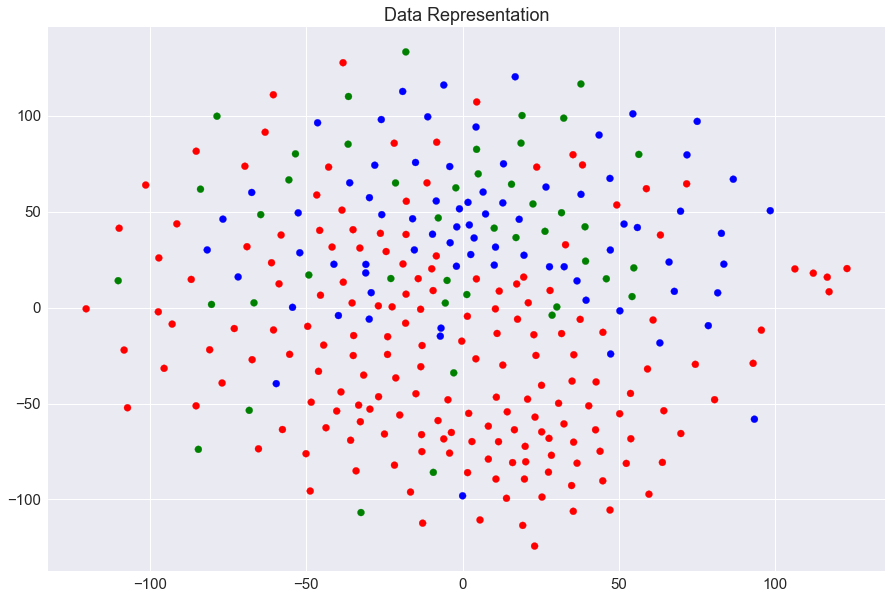

In [69]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y.map({'lived':'red', 'died':'blue', 'euthanized':'green'}));
plt.title('Data Representation')

Что ж, красные точки (lived) можно отделить, чего не скажешь о двух других. Ожидания подтвердились, классы died и euthanized  перемешались и столо бы их слить в один класс еще в самом начале. Но что сделано, то сделано. К тому же, линия между классами явно нелинейная, что наводит на мысль, что линейные модели здесь спасуют, по-крайней без помощи спрямляющих пространств

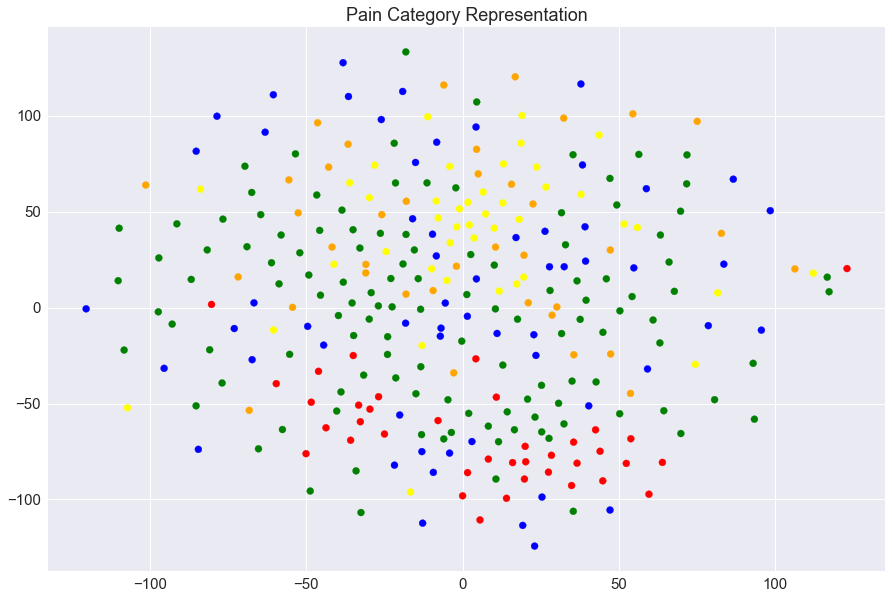

In [70]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1],
            c=X_categorial.apply(lambda x:x.fillna(x.value_counts().index[0]))['pain'].map({'alert':'red',
                                                                                            'depressed':'blue',
                                                                                            'mild_pain':'green',
                                                                                            'severe_pain':'orange',
                                                                                            'extreme_pain':'yellow'}));
plt.title('Pain Category Representation');

Один из высокоскоррелированных признаков с целевой перемнной. В целом объекты неплохо кучкуются, что дает надежду на неплохую классификацию

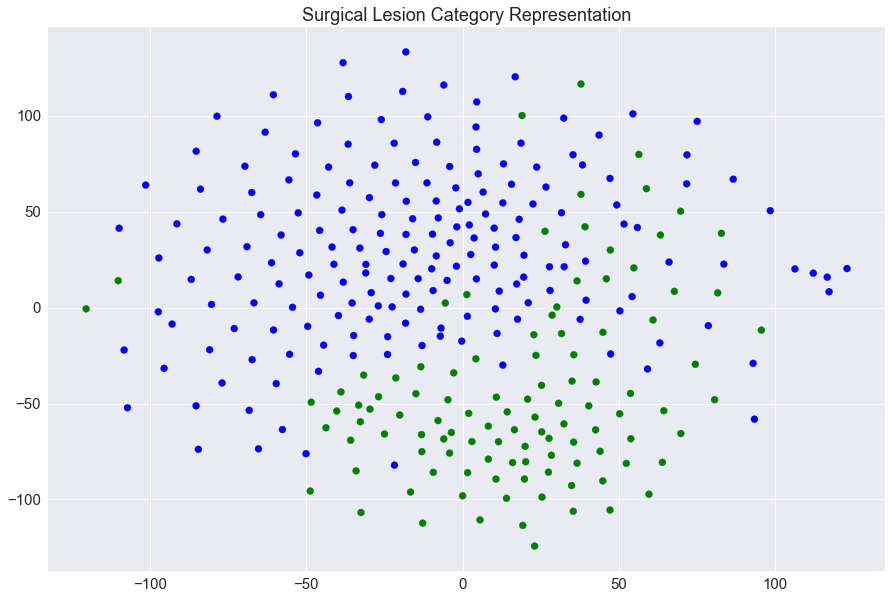

In [71]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1],
            c=X_categorial.apply(lambda x:x.fillna(x.value_counts().index[0]))['surgical_lesion'].map({'no':'green',
                                                                                                       'yes':'blue'}));
plt.title('Surgical Lesion Category Representation');

Образцово-показательный surgical_lesion сходу разделят объекты на два лагеря без всяких вопросов

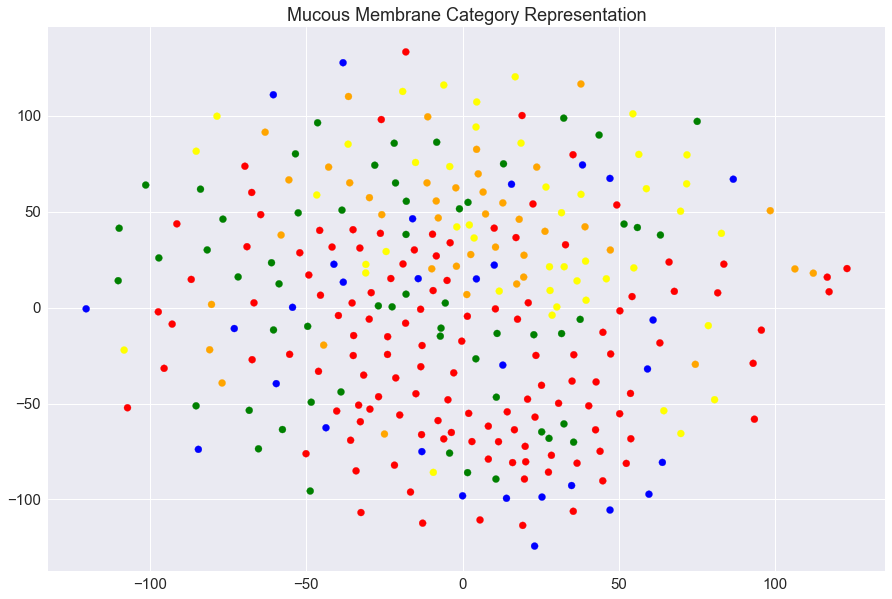

In [72]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1],
            c=X_categorial.apply(lambda x:x.fillna(x.value_counts().index[0]))['mucous_membrane'].map({'normal_pink':'red',
                                                                                            'bright_pink':'blue',
                                                                                            'pale_pink':'green',
                                                                                            'pale_cyanotic':'orange',
                                                                                            'bright_red':'yellow',
                                                                                            'dark_cyanotic':'yellow'}));
plt.title('Mucous Membrane Category Representation');

mucous_mmbrane схож с pain, тоже неплохо

## Делаем модель и отбираем признаки

Сделаем первое небольшое приблежение гиперпараметров с помощью RandomizedSearchCV, чтобы отобрать полезные признаки и убрать мусор

In [73]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_preproc,
                                                    y.map({'lived':1, 'died':2, 'euthanized':3}),
                                                    test_size=0.25,
                                                    random_state=80)

gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective='multiclass',
                         learning_rate=0.1,
                         n_estimators=30,
                         min_data=1,
                         min_data_in_bin=1)

params = {'max_depth': list(range(2, 30, 1)),
          'num_leaves': list(range(5, 200, 10)),
          'min_child_samples': list(range(5, 100, 10)),
          'reg_alpha' : np.arange(1, 10, 1)}
 
rs = RandomizedSearchCV(gbm, params, cv=3, scoring=fbeta_scorer, n_jobs=-1, n_iter=1000, random_state=20)
rs.fit(X_train, y_train);
print(rs.best_params_)

{'max_depth': 9, 'min_child_samples': 85, 'num_leaves': 195, 'reg_alpha': 3}


Проверим их в деле

In [74]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective='multiclass',
                         num_leaves=195,
                         min_child_samples=85,
                         max_depth=9,
                         reg_alpha=3)
gbm.fit(X_train, y_train)
gbm_predictions_train = gbm.predict(X_train)
gbm_predictions_test = gbm.predict(X_test)

print('fbeta_score_train: {0}'.format(round(fbeta_score(y_train, gbm_predictions_train, average='micro', beta=2), 2)))
print('fbeta_score_test: {0}'.format(round(fbeta_score(y_test, gbm_predictions_test, average='micro', beta=2), 2)))

fbeta_score_train: 0.76
fbeta_score_test: 0.73


Очевидно, что бустинг в этой задаче не далеко ушел от обычно леса, к тому же наблюдается небольшое переобучение, но нам пока достаточно, чтобы отбрать признаки

In [75]:
feature_importances = dict(zip(X_train.columns, gbm.feature_importances_))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:12]
feature_importances

[('3_0', 52),
 ('pca_protein', 43),
 ('rate_pulse_relation', 31),
 ('lesion_abdomen_yesdistend_large', 25),
 ('temp_of_extremities_cool', 23),
 ('total_protein', 23),
 ('diff_protein', 22),
 ('packed_cell_volume', 21),
 ('pulse', 17),
 ('pain_mild_pain', 17),
 ('mucous_membrane_normal_pink', 16),
 ('respiratory_rate', 10)]

Нужные признаки по мнению бустинга, остальные равны нулю. Видим, что почти все сгенерированные признаки были по достоинству оценены моделью

In [76]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

classif_selector = SelectKBest(f_classif, k=30)
classif_selector.fit(X_train, y_train)
classif_idxs_selected = classif_selector.get_support(indices=True)
X_train_classif = X_train.iloc[:, classif_idxs_selected]

list(X_train_classif.columns)

['pulse',
 'packed_cell_volume',
 'total_protein',
 'diff_protein',
 'pca_protein',
 'abdomo_appearance_serosanguious',
 'capillary_refill_time_less_3_sec',
 'capillary_refill_time_more_3_sec',
 'mucous_membrane_normal_pink',
 'pain_alert',
 'pain_extreme_pain',
 'peripheral_pulse_absent',
 'peripheral_pulse_normal',
 'peripheral_pulse_reduced',
 'peristalsis_absent',
 'surgical_lesion_no',
 'surgical_lesion_yes',
 'temp_of_extremities_cool',
 'temp_of_extremities_normal',
 'lesion_abdomen_yesdistend_large',
 '1_4',
 '1_n',
 '2_1',
 '2_2',
 '2_n',
 '3_0',
 '3_n',
 '4_0',
 '4_5',
 '4_n']

Также проверили отбор с помощью f_classif. Все признаки бустинга, за исключением парочки, являются подмножеством выбранных f_classif. 

In [77]:
selected_columns = set([x[0] for x in feature_importances]).union(list(X_train_classif.columns))
len(selected_columns)

33

Просто сделаем объединение и получим 33 самых лучших признака для текущей задачи

Снова посмотрим на представление датасета в двумерном пространстве

In [78]:
X_train_selected, X_test_selected = X_train.loc[:, selected_columns], X_test.loc[:, selected_columns]

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_preproc.loc[:, selected_columns])

In [80]:
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(X_scaled)

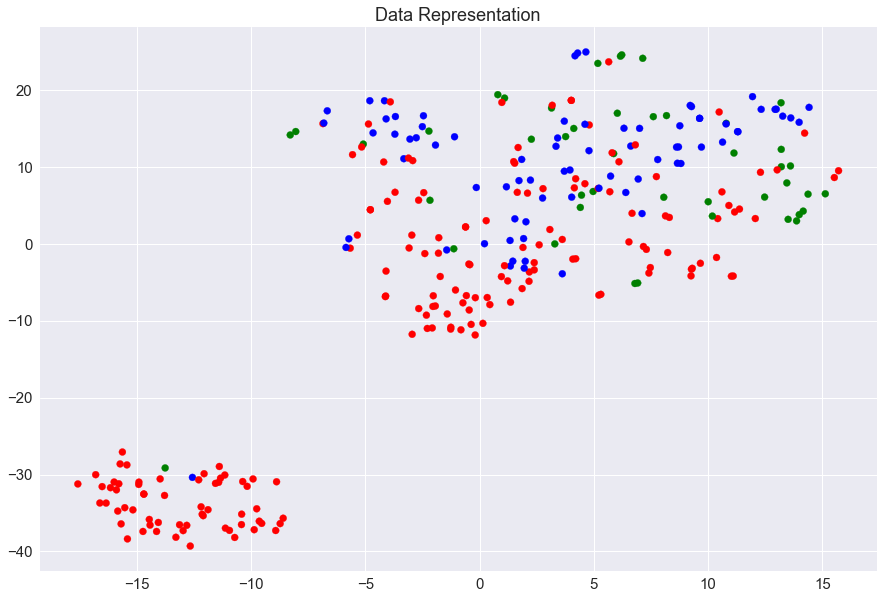

In [81]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y.map({'lived':'red', 'died':'blue', 'euthanized':'green'}));
plt.title('Data Representation');

На глаз вроде бы стало получше, но два ненавистных класса по прежнему не хотят разделяться

Так как данных мало, построим кривые обучения, чтобы оценить стоит ли добавлять данных в датасет. Ванга говорит, что стоит

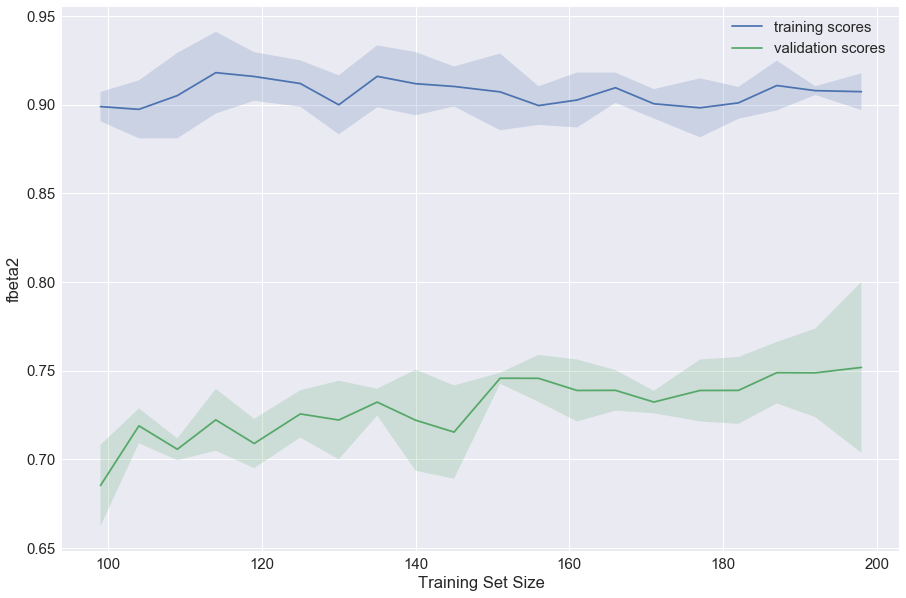

In [82]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve(X_data, y_data):
    train_sizes = np.linspace(0.5, 1, 20)
    
    pipe = Pipeline([('gbm', lgb.LGBMClassifier(boosting_type='gbdt',
                                                objective='multiclass',
                                                num_leaves=195,
                                                min_child_samples=85,
                                                max_depth=9,
                                                reg_alpha=3,
                                                min_data=1,
                                                min_data_in_bin=1))])
    
    N_train, val_train, val_test = learning_curve(pipe, X_data, y_data,
                                                  train_sizes=train_sizes,
                                                  cv=3,
                                                  scoring=fbeta_scorer,
                                                  random_state=15)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('fbeta2')
    plt.legend()

plot_learning_curve(X_preproc.loc[:, selected_columns], y)

Наблюдается ужасное переобучение из-за маленького датасета, но кривые сходятся, а это значит, что добавление данных улучшит ситуацию.

Сделаем стандратный oversampling

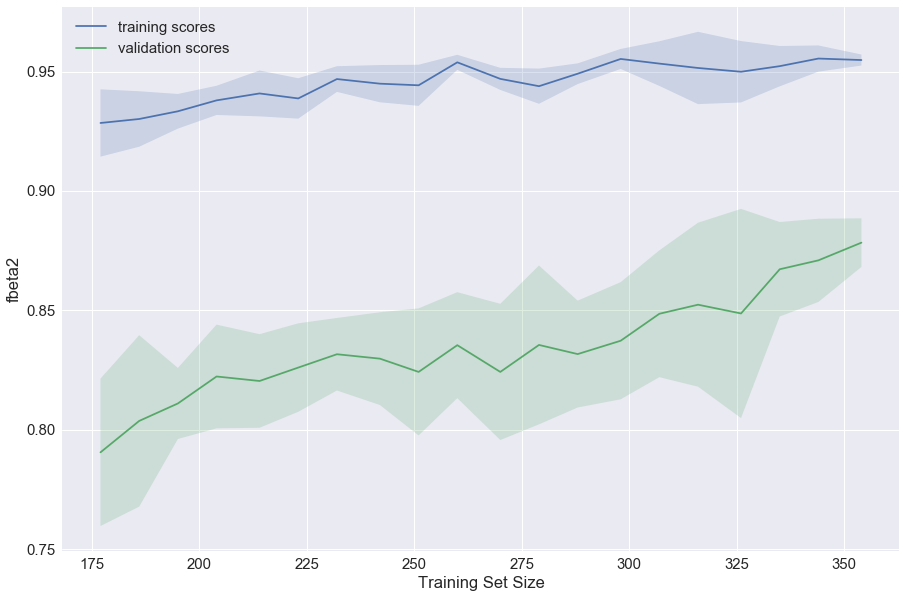

In [83]:
from imblearn.over_sampling import RandomOverSampler 
over_sampler = RandomOverSampler(random_state=17)
X_preproc_sampled, y_sampled = over_sampler.fit_sample(X_preproc.loc[:, selected_columns], y)

from sklearn.utils import shuffle
X_preproc_sampled, y_sampled = shuffle(X_preproc_sampled, y_sampled, random_state=0)

plot_learning_curve(X_preproc_sampled, y_sampled)

Да, ситуация пошла на поправку, но требуются еще данные, которых к сожалению неоткуда взять

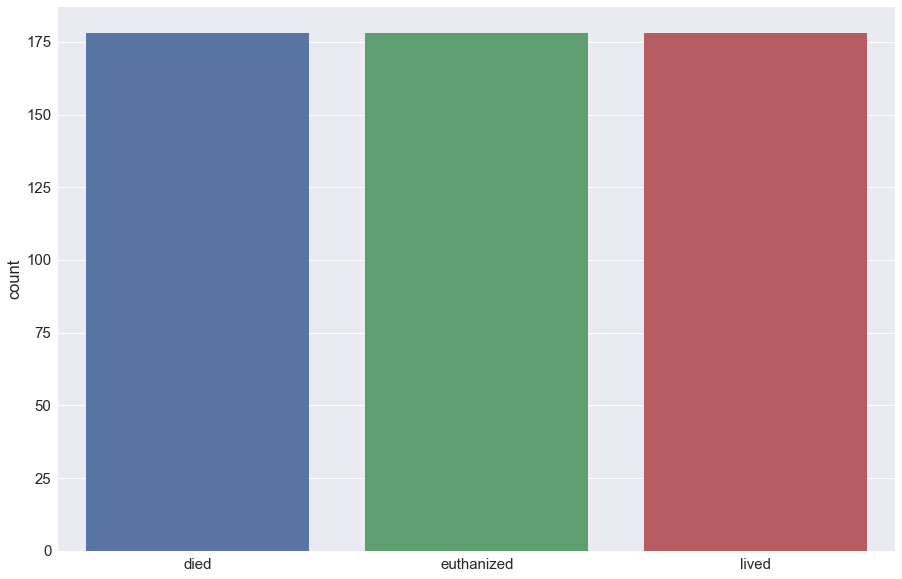

In [84]:
sns.countplot(y_sampled);

Небольшая проверка распределния классов после oversampling

Применим изменения к тренировочной выборке и перемешаем

In [85]:
X_train_sampled, y_train_sampled = over_sampler.fit_sample(X_train_selected, y_train)
X_train_sampled, y_train_sampled = shuffle(X_train_sampled, y_train_sampled, random_state=0)

## Тюнинг гиперпараметров

Должен сказать lightgbm ведет себя очень нестабильно на маленьких данных, всем на заметку. Ну а пока мы подберем регуляризацию L1, чтобы снизить эффект переобучения

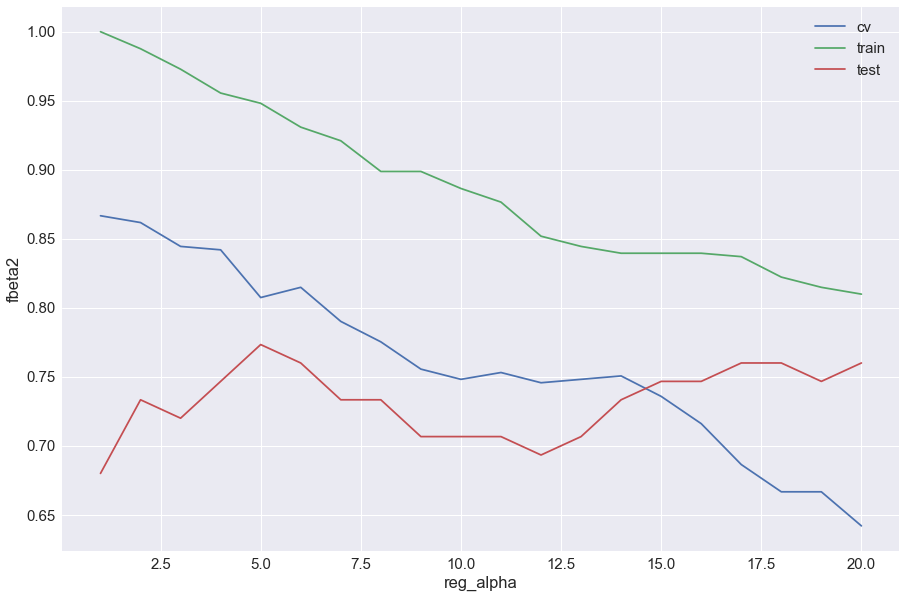

In [86]:
cross_val_scores = list()
train_scores = list()
test_scores = list()
param_values = list()

for param_value in range(1, 21):
    cv = list()
    for i in range(1, 11):
        gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_leaves=195, min_child_samples=85,
                                 max_depth=9, reg_alpha=param_value, min_data=1, min_data_in_bin=1, random_state=i)
        cv.extend(cross_val_score(gbm, X_train_sampled, y_train_sampled, cv=3, scoring=fbeta_scorer))

    gbm.fit(X_train_sampled, y_train_sampled);
    gbm_train_predictions = gbm.predict(X_train_sampled)
    gbm_test_predictions = gbm.predict(X_test_selected)
        
    cross_val_scores.append(np.mean(cv))
    train_scores.append(fbeta_score(y_train_sampled, gbm_train_predictions, average='micro', beta=2))
    test_scores.append(fbeta_score(y_test, gbm_test_predictions, average='micro', beta=2))
    param_values.append(param_value)    
    
plt.plot(param_values, cross_val_scores, label='cv')
plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend(loc='upper right')
plt.xlabel('reg_alpha'); plt.ylabel('fbeta2')
plt.show()

По кривым валидации улучшение ситуации происходит примерно на 14, его и возьмем

Дальше еще один косвенный регуляризатор num_leaves

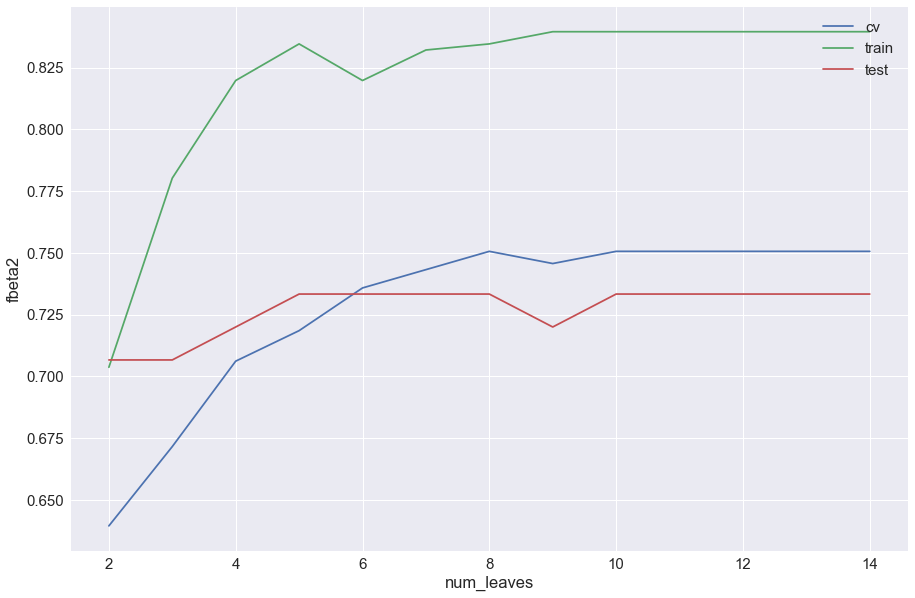

In [87]:
cross_val_scores = list()
train_scores = list()
test_scores = list()
param_values = list()

for param_value in range(2, 15, 1):
    cv = list()
    for i in range(1, 11):
        gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_leaves=param_value, min_child_samples=85,
                                 max_depth=9, reg_alpha=14, min_data=1, min_data_in_bin=1, random_state=i)
        cv.extend(cross_val_score(gbm, X_train_sampled, y_train_sampled, cv=3, scoring=fbeta_scorer))

    gbm.fit(X_train_sampled, y_train_sampled);
    gbm_train_predictions = gbm.predict(X_train_sampled)
    gbm_test_predictions = gbm.predict(X_test_selected)
        
    cross_val_scores.append(np.mean(cv))
    train_scores.append(fbeta_score(y_train_sampled, gbm_train_predictions, average='micro', beta=2))
    test_scores.append(fbeta_score(y_test, gbm_test_predictions, average='micro', beta=2))
    param_values.append(param_value)    
    
plt.plot(param_values, cross_val_scores, label='cv')
plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend(loc='upper right')
plt.xlabel('num_leaves'); plt.ylabel('fbeta2')
plt.show()

Сложно сказать, но я выбрал 6

Подберем процент случайных признаков, которые будут учавствовать в бэггинге

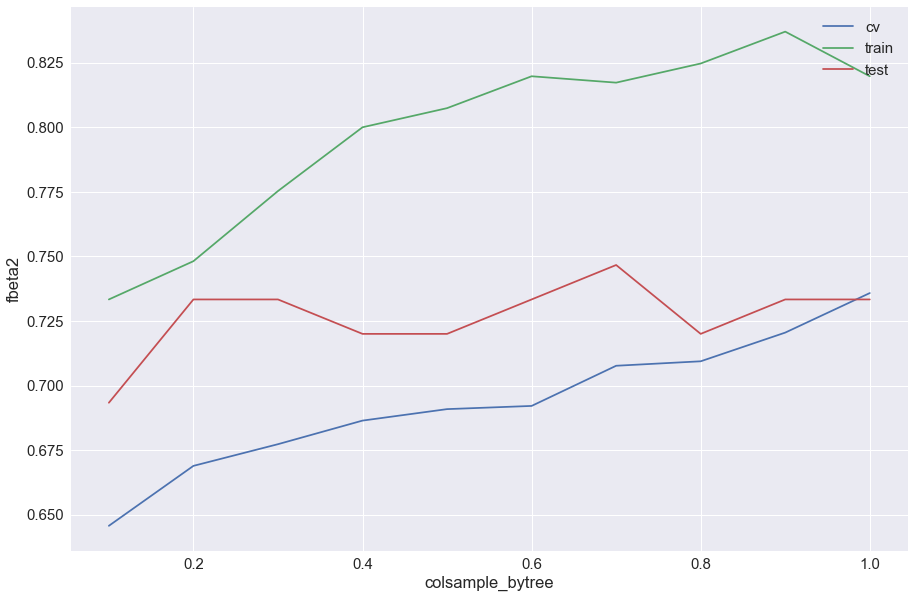

In [88]:
cross_val_scores = list()
train_scores = list()
test_scores = list()
param_values = list()

for param_value in np.arange(0.1, 1.01, 0.1):
    cv = list()
    for i in range(1, 11):
        gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_leaves=6, min_child_samples=85,
                                 max_depth=9, reg_alpha=14, min_data=1, min_data_in_bin=1, random_state=i,
                                 colsample_bytree=param_value)
        cv.extend(cross_val_score(gbm, X_train_sampled, y_train_sampled, cv=3, scoring=fbeta_scorer))

    gbm.fit(X_train_sampled, y_train_sampled);
    gbm_train_predictions = gbm.predict(X_train_sampled)
    gbm_test_predictions = gbm.predict(X_test_selected)
        
    cross_val_scores.append(np.mean(cv))
    train_scores.append(fbeta_score(y_train_sampled, gbm_train_predictions, average='micro', beta=2))
    test_scores.append(fbeta_score(y_test, gbm_test_predictions, average='micro', beta=2))
    param_values.append(param_value)    
    
plt.plot(param_values, cross_val_scores, label='cv')
plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend(loc='upper right')
plt.xlabel('colsample_bytree'); plt.ylabel('fbeta2')
plt.show()

Странно, но самое адекватное это 100%. Видимо, если бы учавствовали все 417 изначальных признаков, мы бы наблюдали другую картину

Далее случайный процент объектов, учавствующих в бэггинге

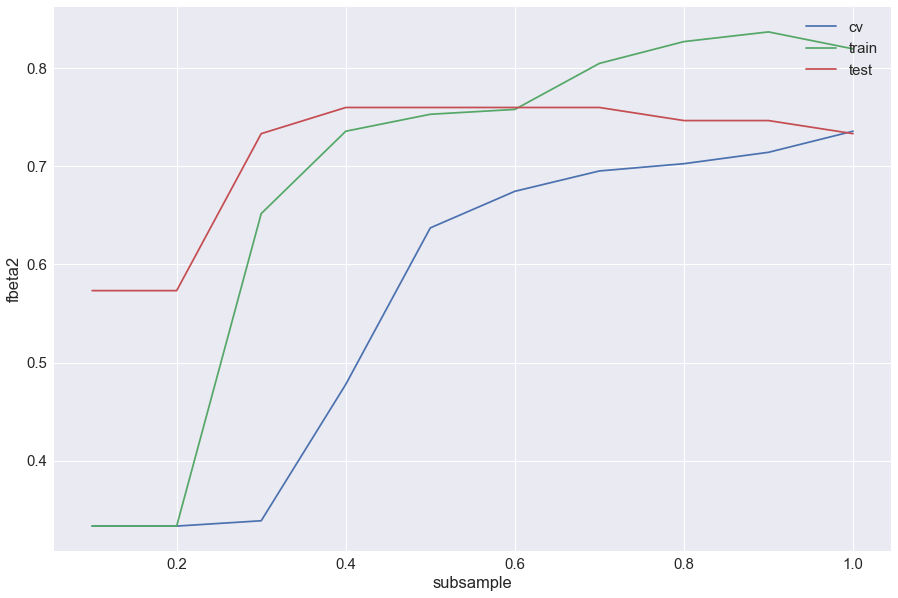

In [89]:
cross_val_scores = list()
train_scores = list()
test_scores = list()
param_values = list()

for param_value in np.arange(0.1, 1.01, 0.1):
    cv = list()
    for i in range(1, 11):
        gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_leaves=6, min_child_samples=85,
                                 max_depth=9, reg_alpha=14, min_data=1, min_data_in_bin=1, random_state=i,
                                 colsample_bytree=1, subsample=param_value)
        cv.extend(cross_val_score(gbm, X_train_sampled, y_train_sampled, cv=3, scoring=fbeta_scorer))

    gbm.fit(X_train_sampled, y_train_sampled);
    gbm_train_predictions = gbm.predict(X_train_sampled)
    gbm_test_predictions = gbm.predict(X_test_selected)
        
    cross_val_scores.append(np.mean(cv))
    train_scores.append(fbeta_score(y_train_sampled, gbm_train_predictions, average='micro', beta=2))
    test_scores.append(fbeta_score(y_test, gbm_test_predictions, average='micro', beta=2))
    param_values.append(param_value)    
    
plt.plot(param_values, cross_val_scores, label='cv')
plt.plot(param_values, train_scores, label='train')
plt.plot(param_values, test_scores, label='test')
plt.legend(loc='upper right')
plt.xlabel('subsample'); plt.ylabel('fbeta2')
plt.show()

Мне кажется 0.6, так именно на таком пороге переобучение сводится до минимума

Создадим финальную модель, на преобработанном датасете, с подобранными гиперпараметрами

In [90]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective='multiclass',
                         min_child_samples=85,
                         reg_alpha=14,
                         num_leaves=6,
                         max_depth=9,
                         colsample_bytree=1,
                         subsample=0.6,
                         min_data=1,
                         min_data_in_bin=1,
                         n_estimators=3000,
                         learning_rate=0.1)
gbm.fit(X_train_sampled, y_train_sampled)
gbm_predictions_train = gbm.predict(X_train_sampled)
gbm_predictions_test = gbm.predict(X_test_selected)

                         
print('fbeta_score_train: {0}'.format(round(fbeta_score(y_train_sampled, gbm_predictions_train, average='micro', beta=2), 2)))
print('fbeta_score_test: {0}'.format(round(fbeta_score(y_test, gbm_predictions_test, average='micro', beta=2), 2)))

fbeta_score_train: 0.8
fbeta_score_test: 0.76


In [91]:
print(classification_report(y_test, gbm_predictions_test))

             precision    recall  f1-score   support

          1       0.84      0.86      0.85        43
          2       0.68      0.71      0.70        21
          3       0.56      0.45      0.50        11

avg / total       0.75      0.76      0.76        75



## Выводы

В итоге получилось все достаточно неплохо, удалось улучшить результат. Надо отметить, что это была не борьба за score, а борьба за переобучение, к которому располагает размер датасета. Победить переобучение полностью не получилось, но хотя бы получилось его снизить. Качество на кросс-валидации стабильно ниже, так как 3 фолда для 200 объектов достаточно много, поэтому я бы ориентировался на обычный hold-out.

По classification_report видно, что модель находит только 71% из класса died. В реальной задаче я бы не допустил ни одну модель, с recall по классам died и euthanized меньше 95%, к сожалению с таким объемом данных этого почти невозможно.

Кроме того меня немного удивило, то что precision соизмерим с recall по всем классам, видимо beta=2 оказалось недостаточно. Ну и тонкой нитью тянувшаеся эпопея с died/euthanized, привела нас к выводу, что их нужно было все-таки объединить.

Как улучшить?
- основаное это добавить данных
- объеденить died/euthanized
- усилить вес recall для died/euthanized
- отобрать fbeta по необходимому порогу
- более глубокие feature engineering и feature selection
- более точный подбор гиперпараметров
- ансамбль моделей